In [1]:
# External libraries (not including Pytorch)
import numpy as np
import sympy as sy
import matplotlib.pyplot as plt

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import functional as F

# Included in Python standard library
import time
import math
import random
from itertools import combinations


%matplotlib inline

use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'

# Click on [ ] to run the hidden utils cells 

'Tesla T4'

## model.py

In [2]:
def TT_metric_batchwise(device, seqs_1, seqs_2, seqs_1_lens, seqs_2_lens, length_, algo="ipot", order=1, penalty=20, beta=10, n_sink=5, n_ipot=1):
  """ 
  Calculate approximations of TT-metric between all pairs of sequences in two respective sequence
  batches and return the approximations in form of a matrix (TT_approx) containing for every pair of
  sequences their TT-metric approximation.

  Args:
    - seqs_1 (tensor): first batch of sequences
    - seqs_2 (tensor): second batch of sequences
    - seqs_1_lens (tensor): lengths of sequences in seqs_1
    - seqs_2_lens (tensor): lengths of sequences in seqs_2

  Parameters:
    - length_: cutoff length of sequences in both batches, set to the minimum of the two maximal
        sequence lengths in the two batches, ensures that seqs_1 and seqs_2 tensors are of same size
    - algo: approximate TT-metric with either the Sinkhorn algorithm or the IPOT algorithm
    - order: order of the TT-metric
    - penalty: penalty parameter in the TT-metric
    - beta: regularization parameter in Sinkhorn or IPOT algorithm
    - n_sink: number of Sinkhorn iterations, corresponds to inner iterations if algo = "ipot"
    - n_ipot: number of main iterations in IPOT algorithm, ignored when algo = "sink"

  Return:
    - T (tensor): tensor which contains for every pair of sequences in seqs_1 and seqs_2 the cost 
        matrix that corresponds to the primal transport formulation of the TT-metric
    - T (tensor): tensor which contains for every pair of sequences in seqs_1 and seqs_2 the
        transport plan approximation that corresponds to the solution of the primal transport
        formulation of the TT-metric
    - TT_approx (tensor): TT-metric approximation for every pair of sequences in seqs_1 and seqs_2

  """

  X = seqs_1
  Y = seqs_2

  batch_size = X.shape[0]  # number of sequences in each batch

  X_len = seqs_1_lens
  Y_len = seqs_2_lens

  X = X.squeeze()
  Y = Y.squeeze()

  X = X[:, :length_]
  Y = Y[:, :length_]

  X = X.unsqueeze(1) # (batch_size, 1         , length)
  X = X.unsqueeze(3) # (batch_size, 1         , length, 1)
  Y = Y.unsqueeze(0) # (1         , batch_size, length)
  Y = Y.unsqueeze(2) # (1         , batch_size, 1     , length)

  C = torch.abs(X - Y)


  # pad sequences with penalty value
  length_arange_vector = torch.arange(length_, dtype=torch.float64).to(device)
  
  mask_X = length_arange_vector.expand(len(X_len), length_) < X_len.unsqueeze(1)
  mask_Y = length_arange_vector.expand(len(Y_len), length_) < Y_len.unsqueeze(1)

  mask_X = mask_X.unsqueeze(1)              # (batch_size, 1, length)
  mask_X = mask_X.unsqueeze(2)              # (batch_size, 1, 1     , length)
  mask_X = torch.transpose(mask_X, -2, -1)  # (batch_size, 1, length, 1)

  mask_Y = mask_Y.unsqueeze(0)   # (1, batch_size, length)
  mask_Y = mask_Y.unsqueeze(2)   # (1, batch_size, 1     , length)

  mask = mask_X * mask_Y # 1 where index of sequence element smaller than sequence length 0 else

  mask_penalty = torch.logical_not(mask) * penalty 

  C = C * mask
  C += mask_penalty


  C = torch.abs(C) ** order

  T = torch.ones((batch_size, batch_size, length_, length_), requires_grad=True).to(device)
  b = torch.ones((batch_size, batch_size, length_, 1), requires_grad=True).to(device)
  A = torch.exp(-C/beta)

  length_float = 1.0 * length_

  if algo == "sink":
    Q = A
    QT = torch.transpose(Q, 2, 3)

    for i in range(n_sink):
      a = 1/(length_float * torch.matmul(Q, b))
      b = 1/(length_float * torch.matmul(QT, a))

    a_diag = torch.diag_embed(a.squeeze(), dim1=-2, dim2=-1)
    b_diag = torch.diag_embed(b.squeeze(), dim1=-2, dim2=-1)

    T = torch.matmul(a_diag, Q)
    T = torch.matmul(T, b_diag)

  if algo == "ipot":
    for i in range(n_ipot):
      Q = A*T
      QT = torch.transpose(Q, 2, 3)

      for j in range(n_sink):
        a = 1/(length_float * torch.matmul(Q, b))
        b = 1/(length_float * torch.matmul(QT, a))

      a_diag = torch.diag_embed(a.squeeze(), dim1=-2, dim2=-1)
      b_diag = torch.diag_embed(b.squeeze(), dim1=-2, dim2=-1)

      T = torch.matmul(a_diag, Q)
      T = torch.matmul(T, b_diag)

  TT_approx = T * C
  TT_approx = torch.sum(TT_approx, dim=(-2,-1))
  TT_approx = (length_float * TT_approx) ** (1/order)

  return T, C, TT_approx

def xiao_metric_batchwise(device, seqs_1, seqs_2, seqs_1_lens, seqs_2_lens, max_T, length_, reduced_pairing=False):
  """ 
  Calculate Xiao distances between two batches of sequences and return the distances in form of a
  matrix (dist) containing for every pair of sequences their Xiao-metric approximation.

  Args:
    - seqs_1 (tensor): first batch of sequences
    - seqs_2 (tensor): second batch of sequences
    - seqs_1_lens (tensor): lengths of sequences in seqs_1
    - seqs_2_lens (tensor): lengths of sequences in seqs_2

  Parameters:
    - length_: cutoff length of sequences in both batches, set to the minimum of the two maximal
        sequence lengths in the two batches, ensures that seqs_1 and seqs_2 are of same size
    - reduced_pairing: if true only calculate distances between sequence pairs with same index in
        respective batch (done in baseline model) if false calculate distances between all pairs of 
        sequences in batch

  Return:
    - dist: xiao distances between the two batches of sequences

  """

  X = seqs_1
  Y = seqs_2

  X_len = seqs_1_lens
  Y_len = seqs_2_lens

  X = X.squeeze()
  Y = Y.squeeze()

  X = X[:, :length_]
  Y = Y[:, :length_]

  length_arange_vector = torch.arange(length_, dtype=torch.float64).to(device)
  
  maskX = length_arange_vector.expand(len(X_len), length_) < X_len.unsqueeze(1)
  maskY = length_arange_vector.expand(len(Y_len), length_) < Y_len.unsqueeze(1)

  X = X * maskX
  Y = Y * maskY

  X = X + torch.logical_not(maskX) * max_T
  Y = Y + torch.logical_not(maskY) * max_T

  if not reduced_pairing:
    X = X.unsqueeze(1) # (batch_size, 1         , length)
    Y = Y.unsqueeze(0) # (1         , batch_size, length)

  dist = torch.abs(X - Y)
  dist = torch.sum(dist, dim=-1)

  return dist

def wasserstein_primal(device, C, algo="ipot", beta=10, n_sink=1, n_ipot=5):
  """ 
  Calculate primal Wasserstein distance between sample distributions of the sequence batches based
  on the cost matrix that contains their pairwise distances (according to xiao-metric or TT-metric).

  Args:
    - C: cost matrix containing pairwise distances of two sequence batches

  Parameters:
    - algo: solve Wasserstein primal with Sinkhorn distance or IPOT algorithm
    - beta: regularization parameter in Sinkhorn distance or IPOT algorithm
    - n_sink: number of Sinkhorn iterations, corresponds to inner iterations if approx = "ipot"
    - n_ipot: number of main iterations in IPOT algorithm, ignored when approx = "sink"

  Return:
    - dist: approximation of exact Wasserstein distance if approx = "ipot" and regularized
        Wasserstein distance if approx = "sink" (Sinkhorn distance)

  """

  L = C.shape[0] # batch size
  T = torch.ones((L, L), requires_grad=True).to(device)
  b = torch.ones((L), requires_grad=True).to(device)
  A = torch.exp(-C/beta)

  if algo == "sink":
    Q = A
    QT = torch.transpose(Q, -2, -1)

    for i in range(n_sink):
      a = 1/(L * torch.matmul(Q, b))
      b = 1/(L * torch.matmul(QT, a))

    a_diag = torch.diag_embed(a.squeeze(), dim1=-2, dim2=-1)
    b_diag = torch.diag_embed(b.squeeze(), dim1=-2, dim2=-1)

    T = torch.matmul(a_diag, Q)
    T = torch.matmul(T, b_diag)

  if algo == "ipot":
    for i in range(n_ipot):
      Q = A*T
      QT = torch.transpose(Q, -2, -1)

      for j in range(n_sink):
        a = 1/(L * torch.matmul(Q, b))
        b = 1/(L * torch.matmul(QT, a))

      a_diag = torch.diag_embed(a.squeeze(), dim1=-2, dim2=-1)
      b_diag = torch.diag_embed(b.squeeze(), dim1=-2, dim2=-1)

      T = torch.matmul(a_diag, Q)
      T = torch.matmul(T, b_diag)

  dist = T*C
  dist = torch.sum(dist, dim=(-2, -1))

  return dist


class Generator(nn.Module):
  """ 
  LSTM based neural network responsible for generating sequences in all three main models by
  transforming a batch of noise sequences into a batch of new sequences.

  Args:
    - x, x_len: batch of noise sequences together with their lengths

  Parameters:
    - hidden_dim: size of hidden layer in the LSTM
    - dropout_p: use a dropout layer in the neural network with this dropout probability

  Return:
    - x, x_len: transformed noise sequences together with their lengths
  """

  def __init__(self, hidden_dim=64, dropout_p=0.1):
    super(Generator, self).__init__()

    self.hidden_dim = hidden_dim
    self.dropout_p = dropout_p

    self.lstm = nn.LSTM(1, hidden_dim, num_layers=1, batch_first=True)
    self.linear = nn.Linear(hidden_dim, 1)
    if dropout_p==None:
      self.variable_layer = nn.Identity()
    else:
      self.variable_layer = nn.Dropout(dropout_p)

  def forward(self, x, x_len):
    x    = torch.nn.utils.rnn.pack_padded_sequence(x, x_len.tolist(), batch_first=True)
    x, _ = self.lstm(x)
    x, _ = torch.nn.utils.rnn.pad_packed_sequence(x, batch_first=True)
    x    = self.variable_layer(x)
    x    = self.linear(x)
    x    = F.elu(x) + 1
    return x, x_len

class Discriminator(nn.Module):
  """ 
  Neural network in the WGAN based model responsible for assigning a score to a batch of sequences 
  (observed or generated). This in turn is used to calculate the Wasserstein distance between the 
  sample distributions of the sequence batches based on the dual formulation of Wasserstein distance.

  Args (in forward method):
    - x, x_len: batch of sequences together with their lengths

  Parameters:
    - hidden_dim: size of hidden layer in the LSTM
    - dropout_p: if specified use a dropout layer in the neural network with this dropout probability

  Return (in forward method):
    - val: assigned score to the batch of sequences

  """

  def __init__(self, hidden_dim=64, dropout_p=None):
    super(Discriminator, self).__init__()

    self.hidden_dim = hidden_dim

    self.lstm = nn.LSTM(1, hidden_dim, num_layers=1, batch_first=True)
    self.dropout = nn.Dropout(p=dropout_p)
    self.linear = nn.Linear(hidden_dim, 1)
    if dropout_p==None:
      self.variable_layer = nn.Identity()
    else:
      self.variable_layer = nn.Dropout(dropout_p)
    
  def forward(self, x, x_len):
    seqlen = x.shape[1]
    length_arange_vector = torch.arange(seqlen, dtype=torch.float64).to(device)
    maskX = length_arange_vector.expand(len(x_len), seqlen) < x_len.unsqueeze(1)

    x    = torch.nn.utils.rnn.pack_padded_sequence(x, x_len.tolist(), batch_first=True)
    x, _ = self.lstm(x)
    x, _ = torch.nn.utils.rnn.pad_packed_sequence(x, batch_first=True)
    x    = self.variable_layer(x)
    x    = self.linear(x)
    x    = x.squeeze()
    x   *= maskX

    val = torch.sum(x, axis=1)
    val /= torch.sum(maskX, axis=1)

    return val

class WGAN(object):  
  """ 
  Main class that implements and trains the WGAN based generative model. The generator network and the 
  discriminator network are instantiated by the Generator and Discriminator class respectively. Both
  neural networks are trained by iterating over the batches of observed sequences and noise 
  sequences using the learning scheme of a WGAN. The model only uses the Xiao metric.

  Args (in train method):
    - ITERS: training iterations of the generator
    - n_discr: number of training iterations of discriminator per generator training iteration

  Parameters:
    - hidden_dim: size of hidden layer in the LSTM of both the generator and the discriminator
    - dropout_p: if specified use a dropout layer in both the generator and the discriminator with
         this dropout probability
    - learn_rate: learning rate in the gradient-descent based optimization in both the generator
        and the discriminator
    - lip_reg: if True (default) use the Lipschitz penality for regularization in the WGAN model
    - LAMBDA_LP: regularization parameter of the regularization

  """

  def __init__(self,
               device,
               hidden_dim=64,
               dropout_p=0.1,
               learn_rate=0.001,
               n_discr=15,
               LAMBDA_LP=0.1,
               lip_reg=True):

    self.device = device
    self.hidden_dim = hidden_dim
    self.dropout_p = dropout_p
    self.learn_rate = learn_rate
    self.n_discr = n_discr
    self.lip_reg = lip_reg
    self.LAMBDA_LP = LAMBDA_LP

    self.generator = Generator(hidden_dim=self.hidden_dim, dropout_p=self.dropout_p)
    self.discriminator = Discriminator(hidden_dim=self.hidden_dim, dropout_p=self.dropout_p)

    self.G_optimizer = optim.Adam(self.generator.parameters(), lr=self.learn_rate, betas=(0.9, 0.99))
    self.D_optimizer = optim.Adam(self.discriminator.parameters(), lr=self.learn_rate, betas=(0.9, 0.99))

    self.generator.to(device)
    self.discriminator.to(device)

  def train(self, ITERS, iterator_real, iterator_noise, max_T, report_every=100):
    # G_loss_history = []

    for i in range(ITERS):

      # Training steps of discriminator
      for _ in range(self.n_discr):
        xi, xi_len = iterator_noise.next_batch()
        eta, eta_len = iterator_real.next_batch()

        length_ = min(np.size(xi, 1), np.size(eta, 1))

        xi = torch.Tensor(xi).to(self.device)
        eta = torch.Tensor(eta).to(self.device)

        xi_len = torch.Tensor(xi_len).to(self.device)
        eta_len = torch.Tensor(eta_len).to(self.device)

        self.D_optimizer.zero_grad()

        gen_seq, gen_seq_len = self.generator(xi, xi_len)

        D_fake = self.discriminator(gen_seq, gen_seq_len)
        D_real = self.discriminator(eta, eta_len)

        D_loss = torch.mean(D_fake) - torch.mean(D_real)

        length_0 = np.minimum(gen_seq.shape[1], eta.shape[1])

        if self.lip_reg:
          seqs_dist = xiao_metric_batchwise(self.device, gen_seq, eta, gen_seq_len, eta_len, max_T, length_0, reduced_pairing=True)

          lip_div = torch.abs(D_real-D_fake)/torch.sqrt(seqs_dist+0.00001)
          lip_div = torch.mean((lip_div-1)**2)

          D_loss += self.LAMBDA_LP * lip_div
          reg_pen = lip_div

        D_loss.backward()
        self.D_optimizer.step()

      # Training step of generator
      for _ in range(1):
        xi, xi_len = iterator_noise.next_batch()

        xi = torch.Tensor(xi).to(self.device)
        xi_len = torch.Tensor(xi_len).to(self.device)

        self.G_optimizer.zero_grad()

        gen_seq, gen_seq_len = self.generator(xi, xi_len)

        D_fake = self.discriminator(gen_seq, gen_seq_len)

        G_loss = -torch.mean(D_fake)

        G_loss.backward()
        self.G_optimizer.step()

      if (i+1)%report_every == 0:
        # G_loss_history.append(float(G_loss))
        # moving_avg_G_loss = np.mean(G_loss_history[-5:]) # 5-step moving average

        # print('Training Progress: {:>6d} of {:>6d} || G_loss: {:>8.3f} || G_loss (5-step moving avg): {:>8.3f} || D_loss: {:>8.3f}'.format(i+1, ITERS, G_loss, moving_avg_G_loss, D_loss))
        print('Training Progress: {:>6d} of {:>6d} || G_loss: {:>8.3f} || D_loss: {:>8.3f}'.format(i+1, ITERS, G_loss, D_loss))

class Sinkhorn(object): 
  """ 
  Main class that implements and trains the Sinkhorn distance based generative model. The generator 
  network is instantiated by the Generator class. The generator network is trained with respect to 
  loss function given by the wasserstein_primal that calculates the Sinkhorn distance between sample
  distributions of the generated sequences and the observed sequences.

  Args (in train method):
    - ITERS: training iterations of the generator
    - n_ipot_TT: number of main iterations in IPOT approximation of TT-metric
    - n_sink_TT: number of Sinkhorn iterations in Sinkhorn or IPOT approximation of TT-metric
    - beta_TT: regularization parameter in Sinkhorn or IPOT approximation of TT-metric
    - algo_TT: use Sinkhorn or IPOT approximation of TT-metric

  Parameters:
    - hidden_dim: size of hidden layer in the LSTM of the generator
    - dropout_p: if specified use a dropout layer in the generator with this dropout probability
    - learn_rate: learning rate in the gradient-descent based optimization of the generator
    - n_sink: number of Sinkhorn iterations used for calculating the Sinkhorn distance
    - beta: regularization parameter in the Sinkhorn distance calculation
    - metric: use the Xiao-metric or the TT-metric as metric for the sequences

  """ 

  def __init__(self,
               device,
               hidden_dim=64,
               dropout_p=0.1,
               learn_rate=0.001,
               n_sink=10,
               metric='TT',
               beta=50):

    self.device = device
    self.hidden_dim = hidden_dim
    self.dropout_p = dropout_p
    self.learn_rate = learn_rate
    self.n_sink = n_sink
    self.metric = metric
    self.beta = beta

    self.generator = Generator(hidden_dim=self.hidden_dim, dropout_p=self.dropout_p)

    self.G_optimizer = optim.Adam(self.generator.parameters(), lr=self.learn_rate, betas=(0.9, 0.99))

    self.generator.to(device)

  def train(self, ITERS, iterator_real, iterator_noise, max_T, report_every=100,
            n_sink_TT=1, n_ipot_TT=10, beta_TT=None, algo_TT='ipot'):
    
    if beta_TT == None:
      beta_TT = max_T/20

    G_loss_history = []

    for i in range(ITERS):
      # Training step of generator
    
      noise_seqs, noise_seqs_lens = iterator_noise.next_batch()
      real_seqs, real_seqs_lens = iterator_real.next_batch()

      length_ = min(np.size(noise_seqs, 1), np.size(real_seqs, 1))

      noise_seqs = torch.Tensor(noise_seqs).to(self.device)
      real_seqs = torch.Tensor(real_seqs).to(self.device)

      noise_seqs_lens = torch.Tensor(noise_seqs_lens).to(self.device)
      real_seqs_lens = torch.Tensor(real_seqs_lens).to(self.device)

      self.generator.zero_grad()

      gen_seqs, gen_seqs_lens = self.generator(noise_seqs, noise_seqs_lens)

      if self.metric == 'TT':
        C = TT_metric_batchwise(self.device, gen_seqs, real_seqs, gen_seqs_lens, real_seqs_lens,
                      length_=length_,
                      algo=algo_TT,
                      order=1,
                      penalty=max_T/2,
                      beta=beta_TT,
                      n_sink=n_sink_TT,
                      n_ipot=n_ipot_TT)[2]
      else:
        C = xiao_metric_batchwise(self.device, gen_seqs, real_seqs, gen_seqs_lens, real_seqs_lens, max_T, length_=length_)

      loss = wasserstein_primal(self.device, C, algo="sink", beta=self.beta, n_sink=self.n_sink)
      loss.backward()

      self.G_optimizer.step()

      if (i+1)%report_every == 0:
        G_loss_history.append(float(loss))
        moving_avg_G_loss = np.mean(G_loss_history[-5:]) # 5-step moving average

        print('Training Progress: {:>6d} of {:>6d} || G_loss: {:>8.3f} || G_loss (5-step moving avg): {:>8.3f}'.format(i+1, ITERS, loss, moving_avg_G_loss))

class IPOT(object):
  """ 
  Main class that implements and trains the IPOT based generative model. The generator network is 
  instantiated by the Generator class. The generator network is trained with respect to 
  loss function given by the wasserstein_primal that calculates the Wasserstein distance between
  sample distributions of the generated sequences and the observed sequences based on the IPOT
  algorithm.

  Args (in train method):
    - ITERS: training iterations of the generator
    - n_ipot_TT: number of main iterations in IPOT approximation of TT-metric
    - n_sink_TT: number of Sinkhorn iterations in Sinkhorn or IPOT approximation of TT-metric
    - beta_TT: regularization parameter in Sinkhorn or IPOT approximation of TT-metric
    - algo_TT: use Sinkhorn or IPOT approximation of TT-metric

  Parameters:
    - hidden_dim: size of hidden layer in the LSTM of the generator
    - dropout_p: if specified use a dropout layer in the generator with this dropout probability
    - learn_rate: learning rate in the gradient-descent based optimization of the generator
    - n_ipot: number of main (outer) iterations in the IPOT algorithm for calculating the
        Wasserstein distance between sequence batches
    - n_sink: number of Sinkhorn (inner) iterations in the IPOT algorithm
    - beta: regularization parameter in the IPOT algorithm
    - metric: use the Xiao-metric or the TT-metric as metric for the sequences

  """ 

  def __init__(self,
               device,
               hidden_dim=64,
               dropout_p=0.1,
               learn_rate=0.001,
               n_sink=1,
               n_ipot=10,
               metric='TT',
               beta=50):

    self.device = device
    self.hidden_dim = hidden_dim
    self.dropout_p = dropout_p
    self.learn_rate = learn_rate
    self.n_sink = n_sink
    self.n_ipot = n_ipot
    self.metric = metric
    self.beta = beta

    self.generator = Generator(hidden_dim=self.hidden_dim, dropout_p=self.dropout_p)

    self.G_optimizer = optim.Adam(self.generator.parameters(), lr=self.learn_rate, betas=(0.9, 0.99))

    self.generator.to(device)

  def train(self, ITERS, iterator_real, iterator_noise, max_T, report_every=100,
            n_sink_TT=1, n_ipot_TT=10, beta_TT=None, algo_TT='ipot'):

    if beta_TT == None:
      beta_TT = max_T/20

    G_loss_history = []

    for i in range(ITERS):
      # Training step of generator
    
      noise_seqs, noise_seqs_lens = iterator_noise.next_batch()
      real_seqs, real_seqs_lens = iterator_real.next_batch()

      length_ = min(np.size(noise_seqs, 1), np.size(real_seqs, 1))

      noise_seqs = torch.Tensor(noise_seqs).to(self.device)
      real_seqs = torch.Tensor(real_seqs).to(self.device)

      noise_seqs_lens = torch.Tensor(noise_seqs_lens).to(self.device)
      real_seqs_lens = torch.Tensor(real_seqs_lens).to(self.device)

      self.generator.zero_grad()

      gen_seqs, gen_seqs_lens = self.generator(noise_seqs, noise_seqs_lens)

      if self.metric == 'TT':
        C = TT_metric_batchwise(self.device, gen_seqs, real_seqs, gen_seqs_lens, real_seqs_lens,
                      length_=length_,
                      algo=algo_TT,
                      order=1,
                      penalty=max_T/2,
                      beta=beta_TT,
                      n_sink=n_sink_TT,
                      n_ipot=n_ipot_TT)[2]
      else:
        C = xiao_metric_batchwise(self.device, gen_seqs, real_seqs, gen_seqs_lens, real_seqs_lens, max_T, length_=length_)

      loss = wasserstein_primal(self.device, C, algo="ipot", beta=self.beta, n_sink=self.n_sink, n_ipot=self.n_ipot)
      loss.backward()

      self.G_optimizer.step()

      if (i+1)%report_every == 0:
        G_loss_history.append(float(loss))
        moving_avg_G_loss = np.mean(G_loss_history[-5:]) # 5-step moving average

        print('Training Progress: {:>6d} of {:>6d} || G_loss: {:>8.3f} || G_loss (5-step moving avg): {:>8.3f}'.format(i+1, ITERS, loss, moving_avg_G_loss))

## data.py

In [3]:
# homogeneous Poisson process
def create_hom_poisson(mean, n_samples = 100, max_T = 100, min_seq_len = 2):
  samples = []
  i = 0
  while True:
    seq = []
    t = 0
    while True:
      intens1 = mean
      dt = np.random.exponential(1/intens1)
      new_t = t + dt
      if new_t > max_T:
        break
        
      intens2 = mean
      u = np.random.uniform()
      if intens2/intens1 >= u:
        seq.append(new_t)
      t = new_t
    if len(seq)>1:
      samples.append(seq) 
      i+=1
    if i==n_samples:
      break

  samples = [seq for seq in samples if len(seq)>min_seq_len]

  return samples


# Hawkes process (github.com/stmorse/hawkes)
class HawkesProcess:
  def __init__(self, params={'alpha': 0.8,'mu': 0.1, 'omega': 1.0}):
    self.data = []
    self.alpha, self.mu, self.omega = params['alpha'], np.array(params['mu']), params['omega']
    self.dim = 1

  def generate_seq(self, horizon):
    self.data = []

    Istar = np.sum(self.mu)
    s = np.random.exponential(scale=1./Istar)

    n0 = 0
    self.data.append([s, n0])

    lastrates = self.mu

    decIstar = False
    while True:
      tj, uj = self.data[-1][0], int(self.data[-1][1])

      if decIstar:
        Istar = np.sum(rates)
        decIstar = False
      else:
        Istar = np.sum(lastrates) + self.omega * self.alpha

      s += np.random.exponential(scale=1./Istar)
      rates = 0.1 + np.exp(-self.omega * (s - tj)) * (self.alpha * self.omega + lastrates - 0.1)

      diff = Istar - np.sum(rates)

      n0 = np.random.choice(np.arange(1+1), 1, p=(np.append(rates, diff) / Istar))

      if n0 < 1:
        self.data.append([s, n0])
        lastrates = rates.copy()
      else:
        decIstar = True

      if s >= horizon:
        self.data = np.array(self.data)
        self.data = self.data[self.data[:,0] < horizon]
        return list(self.data[:,0])

def create_hawkes(params = {'alpha': 0.8,'mu': 0.1, 'omega': 1.0}, n_samples=10, max_T=20, min_seq_len = 2):
  hawkes_process = HawkesProcess(params=params)
  samples = [hawkes_process.generate_seq(max_T) for _ in range(n_samples)]
  samples = [seq for seq in samples if len(seq)>min_seq_len]

  return samples

def get_residuals_hawkes(sequences, params = {'alpha': 0.8,'mu': 0.1, 'omega': 1.0}, max_T=20):
  integrals = []
  correlation = []
  alpha = params['alpha']
  mu = params['mu']

  for seq in sequences:
    seq = np.sort(seq)
    residuals = []

    for i in range(len(seq)-1):
      residual = (seq[i+1]-seq[i])*mu + alpha * np.sum(np.exp(-(seq[i]-seq[:i+1]))-np.exp(-(seq[i+1]-seq[:i+1])))
      residuals.append(residual)

    residuals = residuals
    integrals += residuals

  return np.array(integrals)


# inhomogeneous Poisson process
def create_inhom_poisson(func_expr, n_samples = 100, max_T = 100, min_seq_len = 2):
  samples = []

  x = sy.Symbol("x")
  f = sy.lambdify(x, func_expr, "numpy")

  for i in range(n_samples):
    curr_sample = []
    index = []
    t = 0

    while t<max_T:
      intens1 = np.max(f(np.arange(t, max_T, 0.1)))
      dt = np.random.exponential(1/intens1)
      new_t = t + dt
      if new_t > max_T:
        break

      intens2 = f(new_t)
      u = np.random.uniform()
      if intens2/intens1 >= u:
        curr_sample.append(new_t)
      t = new_t

    samples.append(curr_sample)

  samples = [seq for seq in samples if len(seq)>min_seq_len]

  return samples

def get_residuals_inhom_poisson(sequences, func_expr, max_T=100):
  integrals = []
  correlations = []

  x = sy.Symbol("x")
  f_int = sy.integrate(func_expr, x)
  f_int = sy.lambdify(x, f_int, "numpy")

  for seq in sequences:
    seq = np.sort(seq)

    int_values = f_int(seq)

    residuals = int_values[1:] - int_values[:-1]
    residuals = residuals.tolist()
    integrals += residuals

  return np.array(integrals)


# inhomogeneous Poisson process with gaussian kernels as intensity function
class IntensitySumGaussianKernel:
  def __init__(self, k=2, centers=[2, 4], stds=[1, 1], coefs= [1, 1]):
    self.k = len(centers)
    self.centers = centers
    self.stds = stds
    self.coefs = coefs
  def getValue(self, t):
    inten = 0
    for i in range(self.k):
      inten += self.coefs[i]*(np.exp(-(t-self.centers[i])**2/(2*self.stds[i]**2))/np.sqrt(2*np.pi*self.stds[i]**2))
    return inten
  def getUpperBound(self, from_t, to_t):
    max_val = max(self.getValue(from_t), self.getValue(to_t))
    for i in range(self.k):
      max_val = max(max_val, self.getValue(self.centers[i]))
    for i in range(self.k-1):
      point = (self.coefs[i]*self.centers[i]/self.stds[i] + self.coefs[i+1]*self.centers[i+1]/self.stds[i+1])/(self.coefs[i]/self.stds[i] + self.coefs[i+1]/self.stds[i+1])
      max_val = max(max_val, self.getValue(point))
    return max_val

def create_inhom_poisson_gauss_kernels(intens_gauss_kernels, n_samples = 100, max_T = 100):
  sequences = []
  i = 0
  while True:
    seq = []
    t = 0
    while True:
      intens1 = intens_gauss_kernels.getUpperBound(t, max_T)
      dt = np.random.exponential(1/intens1)
      new_t = t + dt
      if new_t > max_T:
        break
        
      intens2 = intens_gauss_kernels.getValue(new_t)
      u = np.random.uniform()
      if intens2/intens1 >= u:
        seq.append(new_t)
      t = new_t
    if len(seq)>1:
      sequences.append(seq) 
      i+=1
    if i==n_samples:
      break
  return sequences

def get_residuals_inhom_poisson_gauss_kernels(sequences, params):
  integrals = []
  n_kernels = len(params['coef'])
  for seq in sequences:
    integral = []
    seq = np.asarray(seq)
    seq = np.sort(seq)
    for i in range(len(seq)-1):
      integral_delta = 0
      for j in range(n_kernels):
        # integral_delta += np.sum( params['coef'][j] * (stats.norm.cdf(seq[i+1], params['center'][j], params['std'][j]) - stats.norm.cdf(seq[i], params['center'][j], params['std'][j]) ) )
        integral_delta += np.sum( params['coef'][j]) * (normalcdf(seq[i+1], params['center'][j], params['std'][j]) - (normalcdf(seq[i], params['center'][j], params['std'][j]) ) )
      integral.append(integral_delta)
    integrals+=integral
  return np.array(integrals)

# iterator to create batches of sequences which are padded to maximum sequence length in batch
class PaddedDataIterator:
  def __init__(self, sequences, batch_size, pad_elem = -1, sort_by_len = True):
    self.sort_by_len = sort_by_len
    self.sequences = sequences
    self.length = [len(item) for item in self.sequences]
    self.batch_size = batch_size
    self.size = len(self.sequences)
    self.cursor = 0
    self.pad_elem = pad_elem

  def shuffle(self):
    random.shuffle(self.sequences)
    self.length = [len(item) for item in self.sequences]
    self.cursor = 0

  def next_batch(self):
    if self.cursor+self.batch_size > self.size:
      self.shuffle()
    res = self.sequences[self.cursor:self.cursor + self.batch_size]
    seqlen = self.length[self.cursor:self.cursor + self.batch_size]
    self.cursor += self.batch_size

    if self.sort_by_len:
      res.sort(key=lambda s: len(s), reverse=True)
      seqlen.sort(reverse=True)

    max_len = max(seqlen)
    x = np.ones([self.batch_size, max_len, 1], dtype=np.float32) * self.pad_elem
    for i, x_i in enumerate(x):
      x_i[:seqlen[i],0] = res[i]

    return x, np.asarray(seqlen)


# create data used for the diagnostic plots and potentially other plots
class CreateValidationData:
  def __init__(self, seqs_noise, seqs_real, n_seqs, device):
    self.device = device
    self.n_seqs = min(n_seqs, min(len(seqs_noise), len(seqs_real)))

    self.seqs_noise = seqs_noise[:n_seqs]
    self.seqs_real = seqs_real[:n_seqs]

    iterator_noise = PaddedDataIterator(self.seqs_noise, self.n_seqs, sort_by_len=True)
    iterator_real  = PaddedDataIterator(self.seqs_real, self.n_seqs, sort_by_len = True)

    noise_seqs, noise_seqs_lens = iterator_noise.next_batch()
    real_seqs, real_seqs_lens  = iterator_real.next_batch()

    self.batch_noise_seqs = torch.Tensor(noise_seqs).to(self.device)
    self.batch_noise_seqs_lens = torch.Tensor(noise_seqs_lens).to(self.device)

    self.batch_real_seqs  = torch.Tensor(real_seqs).to(self.device)
    self.batch_real_seqs_lens = torch.Tensor(real_seqs_lens).to(self.device)


# Get emperical intensity of sequences
def get_intensity(sequences, T = None, n_t = None, t0 = None):
  if T is None:
    T = max([max(seq) for seq in sequences])
  if n_t is None:
    n_t = 50
  if t0 is None:
    t0 = 0

  dt = (T-t0)/n_t
  ts = np.arange(t0,T,dt)
  n_seqs = len(sequences)
  lens = np.zeros((n_seqs,1))
  cnt = np.zeros((n_t,1))

  for i in range(n_seqs):
    seq = sequences[i]
    j = 0
    k = 0
    for t in np.arange(t0+dt,T+dt,dt):
      while (j < len(seq) and seq[j] <= t):
        j = j + 1
      cnt[k] = cnt[k] + j
      k = k + 1

  dif = np.zeros((len(cnt),1))
  dif[0] = cnt[0]
  for i in range(len(cnt)-1):
    dif[i+1] = cnt[i+1]-cnt[i]
  intensity = dif/(n_seqs)/dt

  return ts, intensity 


## analysis.py

In [4]:

def plot_sample_gen_real_noise(seqs_gen=None, seqs_real=None, seqs_noise=None, intens_func=None, plot_intens_func=True, max_T=100, n_samples=10, size=4):

  # number of plots and positions
  n_plots = 0
  i_gen = 0
  i_real = 0
  i_noise = 0
  if seqs_gen != None:
    n_plots += 1
    i_real += 1
    i_noise += 1
  if seqs_real != None:
    n_plots += 1
    i_noise += 1
  if seqs_noise != None:
    n_plots += 1

  fig, axs = plt.subplots(1, n_plots, figsize=((4/3) * size * n_plots, size), facecolor='w', edgecolor='k')

  if seqs_gen != None:
    plot_sample(axs[i_gen], seqs_gen, n_samples, max_T=max_T, label='Sample of generated sequences', intens_func=intens_func, plot_intens_func=plot_intens_func)
  if seqs_real != None:
    plot_sample(axs[i_real], seqs_real, n_samples, max_T=max_T, label='Sample of real sequences', intens_func=intens_func, plot_intens_func=plot_intens_func)
  if seqs_noise != None:
    plot_sample(axs[i_noise], seqs_noise, n_samples, max_T=max_T, label='Sample of noise sequences', intens_func=intens_func, plot_intens_func=plot_intens_func, is_noise=True)

  plt.show()


def plot_sample(ax, seqs, n_samples, max_T, label='', intens_func=None, plot_intens_func=True, is_noise=False):

  if (intens_func != None) and (plot_intens_func == True):
    x = sy.Symbol("x") 
    intens_func_ = sy.lambdify(x, intens_func, "numpy")
    x_vals = np.arange(0, max_T, 0.1)
    intens_vals = intens_func_(x_vals)
    max_val = np.max(intens_vals)
    gen_ts_inten, gen_inten = get_intensity(seqs, T = max_T, n_t=50, t0=None)

    ax.set_ylim([0, 3.2*max_val+1.5])
    ax.set_xlim([0, max_T])
    ax.set_yticks([])

    if is_noise == False:
      ax.plot(x_vals, intens_vals, linestyle="--", alpha=1, color = 'black', label="true intens.")
      ax.plot(gen_ts_inten, gen_inten, linewidth=2.1, alpha=0.9, label="emp. intens.")
      ax.set_yticks([0, max_val/2, max_val])
      ax.legend(loc="upper right", prop={"size":10}, framealpha=0.8)

    for i in range(1, n_samples):
      if i > 2:
        ax.scatter(seqs[i], ((i-2)/(n_samples-2))*2*max_val*np.ones_like(seqs[i])+1.2*max_val, c="grey", alpha=0.7)

  else:
    for i in range(1, n_samples):
      ax.scatter(seqs[i], i*np.ones_like(seqs[i]), c="grey", alpha=0.7)

    ax.set_xlim([0, max_T])
    ax.set_yticks([])

  ax.set_xlabel(label, fontsize=14, labelpad=15)
  ax.xaxis.set_label_position('top')


def plot_diagnostics(gen_seqs, data_type, max_T, params_hawkes=None, gauss_params=None, intens_func=None, show_intens_func=True, conf_bands=True, n_bins=12, size=4):

  # Residuals and uniform transformation
  if data_type == "hawkes":
    res = get_residuals_hawkes(gen_seqs, params=params_hawkes)

  if data_type == "inhom_poisson":
    res = get_residuals_inhom_poisson(gen_seqs, func_expr=intens_func)
    x = sy.Symbol("x")
    f = sy.lambdify(x, intens_func, "numpy")
    x_vals = np.arange(0,max_T,0.1)
    intens_true = f(x_vals)
    max_val = np.max(intens)
    gen_ts_inten, gen_inten = get_intensity(gen_seqs, T = max_T, n_t=50, t0=None)

  if data_type == "inhom_poisson_gauss_kernels":
    res = get_residuals_inhom_poisson_gauss_kernels(gen_seqs, gauss_params)
    x = sy.Symbol("x")
    f = sy.lambdify(x, intens_func, "numpy")
    x_vals = np.arange(0,max_T,0.1)
    intens_true = f(x_vals)
    max_val = np.max(intens_true)
    gen_ts_inten, gen_inten = get_intensity(gen_seqs, T = max_T, n_t=50, t0=None)

  unif = 1 - np.exp(-res)

  fig, axs = plt.subplots(1, 3, figsize=(4*size, size), facecolor='w', edgecolor='k')

  # Emp intensity vs true intensity if inhom Poisson data
  if (data_type == "inhom_poisson" or data_type == "inhom_poisson_gauss_kernels") and (show_intens_func == True):
    axs[0].set_xlim(0, max_T)
    axs[0].set_ylim(0, 1.7*max_val)
    axs[0].plot(gen_ts_inten, gen_inten, linewidth=2.1, alpha=0.9, label="emp. intens.")
    axs[0].plot(np.arange(0, max_T, 0.1), intens_true, linestyle="--", alpha=1, color = 'black', label="true intens.")
    axs[0].legend(loc="upper right", prop={"size":2*size}, framealpha=0.8)
    axs[0].set_xlabel('Empirical intensity of generated sequences', fontsize=14, labelpad=15)
    axs[0].xaxis.set_label_position('top') 

  # Residuals against exp(1)-distribution
  else:
    range_x = 5
    exp_dist_range = np.linspace(0,range_x,200)
    bins_range = np.linspace(0,range_x,50)
    exp_dist = np.exp(-exp_dist_range)
    weights = (n_bins/range_x) * np.ones_like(res)/float(len(res))
    axs[0].hist(res, bins=n_bins, range=(0,range_x), weights=weights, alpha=0.5, edgecolor='black', linewidth=1.2, label=r"emp. density of residuals")
    axs[0].plot(exp_dist_range, exp_dist, linestyle="--", alpha=0.8, color = 'black', label=r"$f(x) = \exp(-x)$")
    axs[0].set_ylim(0, 1.65)
    axs[0].set_xlim(0, range_x)
    axs[0].legend(loc="upper right", prop={"size":2*size}, framealpha=0.8)
    axs[0].set_xlabel('Residual distribution vs. Exp(1)-distribution', fontsize=14, labelpad=15)
    axs[0].xaxis.set_label_position('top') 

  # Ecdf of U_k with confidence bands
  x = np.sort(unif)
  n = len(unif)
  y = np.arange(1, n+1) / n
  unif_x = np.linspace(0,1)
  unif_y = np.linspace(0,1)
  axs[1].plot(unif_x, unif_y, linestyle="--", alpha=0.8, color = 'black', label=r"$f(x) = x$")
  axs[1].plot(x, y, linewidth=2.1, label=r"e.c.d.f of transf. residuals")
  axs[1].set_xlim(0, 1)
  axs[1].set_ylim(0, 1)
  axs[1].set_xlabel('E.c.d.f of transformed residuals', fontsize=14, labelpad=15)
  axs[1].xaxis.set_label_position('top') 

  if conf_bands == True:
    crit_val_a_95 = 1.358099   # critical value of KS distribution for 95% confidence bands
    crit_val_a_99 = 1.95       # critical value of KS distribution for 99% confidence bands
    K_a_95 = crit_val_a_95/np.sqrt(n)   # value for 95% confidence band
    K_a_99 = crit_val_a_99/np.sqrt(n)   # value for 95% confidence band

    axs[1].plot(unif_x, unif_y+K_a_95, linestyle=":", alpha=0.2, color = 'black')
    axs[1].plot(unif_x, unif_y-K_a_95, linestyle=":", alpha=0.2, color = 'black')
    axs[1].plot(unif_x, unif_y+K_a_99, linestyle=":", alpha=0.2, color = 'black')
    axs[1].plot(unif_x, unif_y-K_a_99, linestyle=":", alpha=0.2, color = 'black')

    axs[1].fill_between(unif_x, unif_y+K_a_95, unif_y-K_a_95, alpha=0.2, linewidths=0, color = 'black')  #, label=r"95% conf. band")
    axs[1].fill_between(unif_x, unif_y+K_a_99, unif_y+K_a_95, alpha=0.1, linewidths=0, color = 'black')  #, label=r"99% conf. band")
    axs[1].fill_between(unif_x, unif_y-K_a_99, unif_y-K_a_95, alpha=0.1, linewidths=0, color = 'black')

    axs[1].legend(loc="lower right", prop={"size":2*size}, framealpha=0.8)

  # Scatter plot of (U_k, U_k+1)
  axs[2].scatter(unif[1:], unif[:-1], alpha=0.4)
  axs[2].set_xlim(0, 1)
  axs[2].set_ylim(0, 1)
  axs[2].set_xlabel('Scatter plot of transformed residual pairs', fontsize=14, labelpad=15)
  axs[2].xaxis.set_label_position('top')

  plt.show()

  corcoef = np.round(np.corrcoef(unif[1:], unif[:-1])[0,1], 3)
  # print("Correlation of U_k and U_k+1: ", corcoef)


def plot_residual_analysis_compare_models(noise_tensor, noise_len_tensor, generators, data_type, max_T, intens_func=None, params=None, n_bins=12, conf_bands=True, plot_inten=True, size=6):
  # perform residual analysis on generated sequences for each generator in generators
  
  data_plots = []
  results = []
  unifs = []
  n_models = len(generators)

  with torch.no_grad():
    for generator in generators:
      gen_out, gen_out_len = generator(noise_tensor, noise_len_tensor)
      gen_out = np.squeeze(gen_out.detach().cpu().numpy())
      gen_out_len = np.squeeze(gen_out_len.detach().cpu().numpy()).astype(int)
      data_plot = [seq[:gen_out_len[i]] for i, seq in enumerate(gen_out)]
      data_plots.append(data_plot)

      # Residuals and uniform transformation
      if data_type == "hawkes":
        res = get_residuals_hawkes(data_plot, params=params_hawkes)
        results.append(res)
      if data_type == "self_correcting":
        res = get_residuals_self_correcting(data_plot)
        results.append(res)
      if data_type == "inhom_poisson":
        res = get_residuals_inhom_poisson(data_plot, func_expr=intens_func)
        results.append(res)

      unif = 1 - np.exp(-res)
      unifs.append(unif)

  if plot_inten == True:
    fig, axs = plt.subplots(3, n_models, figsize=(4*size, 3*size), facecolor='w', edgecolor='k') 
  else:
    fig, axs = plt.subplots(2, n_models, figsize=(4*size, 2*size), facecolor='w', edgecolor='k')

  for j in range(n_models):

    if plot_inten == True:
      # Emp intensity of generated against data intensity
      x = sy.Symbol("x")
      func = sy.lambdify(x, intens_func, "numpy")
      x_vals = np.arange(0, max_T, 0.1)
      intens = func(x_vals)
      max_val = np.max(intens)

      gen_ts_inten, gen_inten = get_intensity(data_plots[j], T = max_T, n_t=30, t0=None)

      axs[2,j].set_xlim(0, max_T)
      axs[2,j].set_ylim(0, 1.3*max_val)
      axs[2,j].plot(gen_ts_inten, gen_inten, linewidth=2.1, alpha=0.9, label="emp. intens.")
      axs[2,j].plot(np.arange(0, max_T, 0.1), intens, linestyle="--", alpha=1, color = 'black', label="true intens.")
      axs[2,j].legend(loc="upper right", prop={"size":3*size}, framealpha=0.8)
      axs[2,j].tick_params(axis='both', labelsize=16)

    # Residuals against exp(1)-distribution
    range_x = 5
    exp_dist_range = np.linspace(0,range_x,200)
    bins_range = np.linspace(0,range_x,50)
    exp_dist = np.exp(-exp_dist_range)
    weights = (n_bins/range_x) * np.ones_like(results[j])/float(len(results[j]))
    axs[0,j].hist(results[j], bins=n_bins, range=(0,range_x), weights=weights, alpha=0.5, edgecolor='black', linewidth=1.2, label=r"emp. density of $S$")
    axs[0,j].plot(exp_dist_range, exp_dist, linestyle="--", alpha=1, color = 'black', label=r"$f(x) = \exp(-x)$")
    axs[0,j].set_ylim([0, 1.45])
    axs[0,j].set_xlim([0, range_x])
    axs[0,j].legend(loc="upper right", prop={"size":3*size}, framealpha=0.8)
    axs[0,j].tick_params(axis='both', labelsize=2*size)

    # Ecdf of U_k with confidence bands
    n = len(unifs[j])
    x = np.sort(unifs[j])
    y = np.arange(1, n+1) / n
    unif_x = np.linspace(0,1)
    unif_y = np.linspace(0,1)

    axs[1,j].plot(unif_x, unif_y, linestyle="--", alpha=0.8, color = 'black', label=r"$f(x) = x$")
    axs[1,j].plot(x, y, linewidth=2.1, label=r"emp. c.d.f of $U$")
    axs[1,j].set_xlim([0, 1])
    axs[1,j].set_ylim([0, 1])

    if conf_bands == True:
      crit_val_a_95 = 1.358099   # critical value of KS distribution for 95% confidence bands
      crit_val_a_99 = 1.95       # critical value of KS distribution for 99% confidence bands
      K_a_95 = crit_val_a_95/np.sqrt(n)   # value for 95% confidence band
      K_a_99 = crit_val_a_99/np.sqrt(n)   # value for 95% confidence band

      axs[1,j].plot(unif_x, unif_y+K_a_95, linestyle=":", alpha=0.2, color = 'black')
      axs[1,j].plot(unif_x, unif_y-K_a_95, linestyle=":", alpha=0.2, color = 'black')
      axs[1,j].plot(unif_x, unif_y+K_a_99, linestyle=":", alpha=0.2, color = 'black')
      axs[1,j].plot(unif_x, unif_y-K_a_99, linestyle=":", alpha=0.2, color = 'black')

      axs[1,j].fill_between(unif_x, unif_y+K_a_95, unif_y-K_a_95, alpha=0.2, linewidths=0, color = 'black')  #, label=r"95% conf. band")
      axs[1,j].fill_between(unif_x, unif_y+K_a_99, unif_y+K_a_95, alpha=0.1, linewidths=0, color = 'black')  #, label=r"99% conf. band")
      axs[1,j].fill_between(unif_x, unif_y-K_a_99, unif_y-K_a_95, alpha=0.1, linewidths=0, color = 'black')

      axs[1,j].legend(loc="lower right", prop={"size":3*size}, framealpha=0.8)
      axs[1,j].tick_params(axis='both', labelsize=2*size)

  fontsize = 4*size
  labelpad = 3*size
  axs[0,0].set_xlabel('WGAN', fontsize=fontsize, labelpad=labelpad)
  axs[0,0].xaxis.set_label_position('top')
  axs[0,1].set_xlabel('Sinkhorn distance', fontsize=fontsize, labelpad=labelpad)
  axs[0,1].xaxis.set_label_position('top')
  axs[0,2].set_xlabel('IPOT', fontsize=fontsize, labelpad=labelpad)
  axs[0,2].xaxis.set_label_position('top')


def plot_residual_analysis_compare_models(noise_tensor, noise_len_tensor, generators, data_type, max_T, intens_func=None, params=None, n_bins=12, conf_bands=True, plot_inten=True, size=6):
  # perform residual analysis on generated sequences for each generator in generators
  
  data_plots = []
  results = []
  unifs = []
  n_models = len(generators)

  with torch.no_grad():
    for generator in generators:
      gen_out, gen_out_len = generator(noise_tensor, noise_len_tensor)
      gen_out = np.squeeze(gen_out.detach().cpu().numpy())
      gen_out_len = np.squeeze(gen_out_len.detach().cpu().numpy()).astype(int)
      data_plot = [seq[:gen_out_len[i]] for i, seq in enumerate(gen_out)]
      data_plots.append(data_plot)

      # Residuals and uniform transformation
      if data_type == "hawkes":
        res = get_residuals_hawkes(data_plot, params=params_hawkes)
        results.append(res)
      if data_type == "self_correcting":
        res = get_residuals_self_correcting(data_plot)
        results.append(res)
      if data_type == "inhom_poisson":
        res = get_residuals_inhom_poisson(data_plot, func_expr=intens_func)
        results.append(res)

      unif = 1 - np.exp(-res)
      unifs.append(unif)

  if plot_inten == True:
    fig, axs = plt.subplots(3, n_models, figsize=(4*size, 3*size), facecolor='w', edgecolor='k') 
  else:
    fig, axs = plt.subplots(2, n_models, figsize=(4*size, 2*size), facecolor='w', edgecolor='k')

  for j in range(n_models):

    if plot_inten == True:
      # Emp intensity of generated against data intensity
      x = sy.Symbol("x")
      func = sy.lambdify(x, intens_func, "numpy")
      x_vals = np.arange(0, max_T, 0.1)
      intens = func(x_vals)
      max_val = np.max(intens)

      gen_ts_inten, gen_inten = get_intensity(data_plots[j], T = max_T, n_t=30, t0=None)

      axs[2,j].set_xlim(0, max_T)
      axs[2,j].set_ylim(0, 1.3*max_val)
      axs[2,j].plot(gen_ts_inten, gen_inten, linewidth=2.1, alpha=0.9, label="emp. intens.")
      axs[2,j].plot(np.arange(0, max_T, 0.1), intens, linestyle="--", alpha=1, color = 'black', label="true intens.")
      axs[2,j].legend(loc="upper right", prop={"size":3*size}, framealpha=0.8)
      axs[2,j].tick_params(axis='both', labelsize=16)

    # Residuals against exp(1)-distribution
    range_x = 5
    exp_dist_range = np.linspace(0,range_x,200)
    bins_range = np.linspace(0,range_x,50)
    exp_dist = np.exp(-exp_dist_range)
    weights = (n_bins/range_x) * np.ones_like(results[j])/float(len(results[j]))
    axs[0,j].hist(results[j], bins=n_bins, range=(0,range_x), weights=weights, alpha=0.5, edgecolor='black', linewidth=1.2, label=r"emp. density of $S$")
    axs[0,j].plot(exp_dist_range, exp_dist, linestyle="--", alpha=1, color = 'black', label=r"$f(x) = \exp(-x)$")
    axs[0,j].set_ylim([0, 1.45])
    axs[0,j].set_xlim([0, range_x])
    axs[0,j].legend(loc="upper right", prop={"size":3*size}, framealpha=0.8)
    axs[0,j].tick_params(axis='both', labelsize=2*size)

    # Ecdf of U_k with confidence bands
    n = len(unifs[j])
    x = np.sort(unifs[j])
    y = np.arange(1, n+1) / n
    unif_x = np.linspace(0,1)
    unif_y = np.linspace(0,1)

    axs[1,j].plot(unif_x, unif_y, linestyle="--", alpha=0.8, color = 'black', label=r"$f(x) = x$")
    axs[1,j].plot(x, y, linewidth=2.1, label=r"emp. c.d.f of $U$")
    axs[1,j].set_xlim([0, 1])
    axs[1,j].set_ylim([0, 1])

    if conf_bands == True:
      crit_val_a_95 = 1.358099   # critical value of KS distribution for 95% confidence bands
      crit_val_a_99 = 1.95       # critical value of KS distribution for 99% confidence bands
      K_a_95 = crit_val_a_95/np.sqrt(n)   # value for 95% confidence band
      K_a_99 = crit_val_a_99/np.sqrt(n)   # value for 95% confidence band

      axs[1,j].plot(unif_x, unif_y+K_a_95, linestyle=":", alpha=0.2, color = 'black')
      axs[1,j].plot(unif_x, unif_y-K_a_95, linestyle=":", alpha=0.2, color = 'black')
      axs[1,j].plot(unif_x, unif_y+K_a_99, linestyle=":", alpha=0.2, color = 'black')
      axs[1,j].plot(unif_x, unif_y-K_a_99, linestyle=":", alpha=0.2, color = 'black')

      axs[1,j].fill_between(unif_x, unif_y+K_a_95, unif_y-K_a_95, alpha=0.2, linewidths=0, color = 'black')  #, label=r"95% conf. band")
      axs[1,j].fill_between(unif_x, unif_y+K_a_99, unif_y+K_a_95, alpha=0.1, linewidths=0, color = 'black')  #, label=r"99% conf. band")
      axs[1,j].fill_between(unif_x, unif_y-K_a_99, unif_y-K_a_95, alpha=0.1, linewidths=0, color = 'black')

      axs[1,j].legend(loc="lower right", prop={"size":3*size}, framealpha=0.8)
      axs[1,j].tick_params(axis='both', labelsize=2*size)

  fontsize = 4*size
  labelpad = 3*size
  axs[0,0].set_xlabel('WGAN', fontsize=fontsize, labelpad=labelpad)
  axs[0,0].xaxis.set_label_position('top')
  axs[0,1].set_xlabel('Sinkhorn distance', fontsize=fontsize, labelpad=labelpad)
  axs[0,1].xaxis.set_label_position('top')
  axs[0,2].set_xlabel('IPOT', fontsize=fontsize, labelpad=labelpad)
  axs[0,2].xaxis.set_label_position('top')


def plot_gen_samples_compare_models(noise_tensor, noise_len_tensor, generators, max_T, size=3):
  # for each generator in generators plot a sample of generated sequences

  data_plots = []
  results = []
  unifs = []
  n_models = len(generators)

  with torch.no_grad():
    for generator in generators:
      gen_out, gen_out_len = generator(noise_tensor, noise_len_tensor)
      gen_out = np.squeeze(gen_out.detach().cpu().numpy())
      gen_out_len = np.squeeze(gen_out_len.detach().cpu().numpy()).astype(int)
      data_plot = [seq[:gen_out_len[i]] for i, seq in enumerate(gen_out)]
      data_plots.append(data_plot)

  fig, axs = plt.subplots(1, n_models, figsize=(8*size, size), facecolor='w', edgecolor='k')
  fig.subplots_adjust(hspace = 0.15, wspace= 0.1)

  for j in range(3):

    axs[j].set_xlim(0, max_T)
    axs[j].set_ylim(0, 8)
    axs[j].set_yticks([])

    for i in range(1, 8):
      axs[j].scatter(data_plots[j][i], i*np.ones_like(data_plots[j][i]), c="grey", alpha=0.7)

  fontsize = 8*size
  labelpad = 5*size
  axs[0].set_xlabel('WGAN', fontsize=fontsize, labelpad=labelpad)
  axs[0].xaxis.set_label_position('top')
  axs[1].set_xlabel('Sinkhorn distance', fontsize=fontsize, labelpad=labelpad)
  axs[1].xaxis.set_label_position('top')
  axs[2].set_xlabel('IPOT', fontsize=fontsize, labelpad=labelpad)
  axs[2].xaxis.set_label_position('top')


def plot_metric_comparision_vary_noise_mean_intens(val_data_list, generators, intens_func, max_T, size=6):
  # plot the empirical intensity of generated sequences for varying mean intensity of noise process
  # and compare results of Xiao-metric and TT-metric

  data_plots = []

  with torch.no_grad():
    for i, generator in enumerate(generators):
      if i == 0 or i == 1:
        noise_tensor = val_data_list[0].batch_noise_seqs
        noise_len_tensor = val_data_list[0].batch_noise_seqs_lens
      if i == 2 or i == 3:
        noise_tensor = val_data_list[1].batch_noise_seqs
        noise_len_tensor = val_data_list[1].batch_noise_seqs_lens
      if i == 4 or i == 5:
        noise_tensor = val_data_list[2].batch_noise_seqs
        noise_len_tensor = val_data_list[2].batch_noise_seqs_lens

      data_plot = retrieve_seqs_from_gen(noise_tensor, noise_len_tensor, generator)
      data_plots.append(data_plot)

  fig, axs = plt.subplots(2, 3, figsize=(9*size, 2*size), facecolor='w', edgecolor='k')

  # Emp intensity of generated against data intensity
  x = sy.Symbol("x")
  func = sy.lambdify(x, intens_func, "numpy")
  x_vals = np.arange(0, max_T, 0.1)
  intens = func(x_vals)
  max_val = np.max(intens)

  labels = ['$\lambda_{noise} = \lambda_{observed}$', '$\lambda_{noise} > \lambda_{observed}$', '$\lambda_{noise} < \lambda_{observed}$']

  for i in range(2):
    for j in range(3):

      gen_ts_inten, gen_inten = get_intensity(data_plots[2*j+i], T = max_T, n_t=20, t0=None)

      axs[i,j].set_xlim(0, max_T)
      axs[i,j].set_ylim(0, 1.7*max_val)
      axs[i,j].plot(gen_ts_inten, gen_inten, linewidth=2.1, alpha=0.9, label="emp. intens.")
      axs[i,j].plot(np.arange(0, max_T, 0.1), intens, linestyle="--", alpha=1, color = 'black', label="true intens.")
      if i == 0:
        leg = axs[i,j].legend(loc="upper right", title="Metric: Xiao", framealpha=0.8, bbox_to_anchor=(0.99,0.99))
        leg._legend_box.align = "left"
      if i == 1:
        leg = axs[i,j].legend(loc="upper right", title="Metric: TT", framealpha=0.8, bbox_to_anchor=(0.99,0.99))
        leg._legend_box.align = "left"

      axs[i,j].tick_params(axis='both')

      fontsize = 6*size
      labelpad = 3*size

      if i == 0:
        axs[i,j].set_xlabel(labels[j], fontsize=fontsize, labelpad=labelpad)
        axs[i,j].xaxis.set_label_position('top')


def plot_min_xiao_dist_gen_to_obs(gen_seqs, obs_seqs, max_T, size=6):
  # for each generated sequence in gen_seqs find the closest neighbour (w.r.t. Xiao-distance) in the
  # set of observed sequences in obs_seqs and plot the two sequences side-by-side
  
  obs_seqs_len = [len(s) for s in obs_seqs]
  gen_seqs_len = [len(s) for s in gen_seqs]

  max_seq_len = max(max(gen_seqs_len), max(obs_seqs_len))

  array_obs_seqs = np.ones((len(obs_seqs), max_seq_len)) * max_T
  for i in range(len(obs_seqs)):
    array_obs_seqs[i][:obs_seqs_len[i]] =  obs_seqs[i]

  closest_in_obs = [] # index of closest seq in obs_seqs for each seq in gen_seqs
  dist_closest_in_obs = []

  for i in range(len(gen_seqs)):

    array_gen_seqs = np.ones((len(obs_seqs), max_seq_len)) * max_T

    for j in range(len(obs_seqs)):
      array_gen_seqs[j][:gen_seqs_len[i]] =  gen_seqs[i]

    dists = np.abs(array_obs_seqs - array_gen_seqs)
    dists = np.sum(dists, axis=-1).squeeze()

    ind_closest_seq = dists.argsort()[0]
    dist_closest_seq = dists[ind_closest_seq]

    closest_in_obs.append(ind_closest_seq)
    dist_closest_in_obs.append(dist_closest_seq)

  fig, axs = plt.subplots(1, 2, figsize=(4*size, size), facecolor='w', edgecolor='k')

  axs[0].set_xlim(0, max_T)
  axs[0].set_yticks([])

  axs[1].set_xlim(0, max_T)
  axs[1].set_yticks([])

  n_seqs = min(min(len(gen_seqs), 6), len(obs_seqs))
  for i in range(n_seqs):
    axs[0].scatter(gen_seqs[i], i*np.ones_like(gen_seqs[i]), c="grey", alpha=0.7)

  for i in range(n_seqs):
    axs[1].scatter(obs_seqs[closest_in_obs[i]], i*np.ones_like(obs_seqs[closest_in_obs[i]]), c="grey", alpha=0.7)

  fontsize = 4*size
  labelpad = 2*size
  axs[0].set_xlabel('Generated sequences', fontsize=fontsize, labelpad=labelpad)
  axs[0].xaxis.set_label_position('top')
  axs[1].set_xlabel('Closest neighbour in real sequences', fontsize=fontsize, labelpad=labelpad)
  axs[1].xaxis.set_label_position('top')

## utils.py

In [5]:
def intens_func_from_gauss_params(params):
  x = sy.Symbol("x")
  inten = 0
  for i in range(len(params["center"])):
    inten += params["coef"][i]*(sy.exp(-(x-params["center"][i])**2/(2*params['std'][i]**2))/sy.sqrt(2*sy.pi*params['std'][i]**2))
  return inten

def normalcdf(x, mu, sigma):
  return (1.0 + math.erf((x-mu)/ (sigma*math.sqrt(2.0)))) / 2.0

def retrieve_seqs_from_gen(noise_seqs, noise_seqs_lens, generator):
  gen_out, gen_out_lens = generator(noise_seqs, noise_seqs_lens)
  gen_out = np.squeeze(gen_out.detach().cpu().numpy())
  gen_out_lens = np.squeeze(gen_out_lens.detach().cpu().numpy()).astype(int)
  gen_seqs = [seq[:gen_out_lens[i]] for i, seq in enumerate(gen_out)]

  return gen_seqs

## Generative Modelling and residual analysis (goodness-of-fit analysis)

The performance of the generative models can be checked via residual analysis where it is examined whether the generated sequences follow the theoretical distribution of the observed sequences by means of the time-change theorem for temporal point processes.


For this we consider the (timely ordered) time events $t_i$ each generated sequence $\xi = (t_1, \dots, t_m)$ and apply the time-change formula in order to yield the corresponding residuals
$$
\tau_i = \int_0^{t_i} \lambda^\ast(u) \, du
$$
where $\lambda^\ast$ denotes the conditional itensity function of the observed process. Assuming $\xi$ is sampled from the observed process, the time-change theorem then assesses that the residuals $\tau_i$ form a hom. Poisson process with rate parameter 1 and that, correspondingly, the increments $s_i = \tau_i - \tau_{i-1}$ come from an exponential distribution with rate parameter 1.

Consequently, we can formulate the residual analysis as the assessment of whether the increments $s_i$ follow a unit rate exponential distribution and reject the assumption that the generated sequences follow the theoretical distribution of the observed process if they significantly deviate from the unit rate exponential distribution.

Furthermore, using the formula $f(x) = 1 - \exp(-x)$ which transforms a unit rate exponential distribution into a uniform distribution on the interval $(0,1)$ we can perform a corresponding assessment between the transformed residuals $u_i = f(s_i)$ and the fit towards the uniform distribution on $(0,1)$.




### Inhom. Poisson process
In the following we consider an inhom. Poisson process on the interval $[0,30]$ as our theoretical distribution and compare the performance of the three generative models (WGAN, Sinkhorn, IPOT) via a residual analysis. The metric in all cases is the Xiao-metric.

In [6]:
DATA = 'inhom_poisson' # choose either: hawkes, inhom_poisson, inhom_poisson_gauss_kernels; specify distributions below
BATCH_SIZE = 32

## simulate real/observed data
max_T = 30 # maximum of time interval
SEQ_NUM = 2000 # number of samples in each noise process and observed process

sequences_real = []
intens_func = None
gauss_params = None


## specify intensity function of inhom. Poisson process (use sympy for symbolic function expression)
x = sy.Symbol("x")
intens_func = 1.1 + sy.sin(6*sy.pi*x/max_T - sy.pi/2)
sequences_real = create_inhom_poisson(func_expr=intens_func, n_samples=SEQ_NUM, max_T=max_T, min_seq_len=2)

# ## alternatively: specify intensity function of inhom. Poisson process via gauss kernels
# intensityPoissonGaussianKernels = IntensitySumGaussianKernel(k=2, centers=[5, 5], stds=[10, 20], coefs=[1, 1])
# intens_func = intens_func_from_gauss_params(gauss_params)
# sequences_real = create_inhom_poisson_gauss_kernels(intensityPoissonGaussianKernels, n_samples=SEQ_NUM, max_T=max_T)


## simulate noise samples which are transformed by the generator neural network
lambda0 = np.mean([len(item) for item in sequences_real])/max_T
sequences_noise = create_hom_poisson(mean=lambda0, n_samples=SEQ_NUM, max_T=max_T)


## initialize data iterators for batch-wise training
iterator_noise = PaddedDataIterator(sequences_noise, BATCH_SIZE, pad_elem = -1, sort_by_len=True)
iterator_real  = PaddedDataIterator(sequences_real, BATCH_SIZE, pad_elem = -1, sort_by_len=True)


## print summary statistics of the point process samples
max_seq_len = max([len(seq) for seq in sequences_noise+sequences_real])
avg_seq_len = np.round(np.mean([len(item) for item in sequences_real]), 2)


## Validation data
n_val_seqs = int(1000/(avg_seq_len)) # so that we have roughly 1000 points in all sequences combined
val_data = CreateValidationData(sequences_noise, sequences_real, n_seqs=n_val_seqs, device=device)


print("Number of sequences (with length > 2): %d (real process), %d (noise process)" %(len(sequences_real), len(sequences_noise)))
print("\nMaximal sequence length of real and noise process combined: %d" %(max_seq_len))
print("\nAverage number of points per sequence: ", avg_seq_len)

Number of sequences (with length > 2): 2000 (real process), 2000 (noise process)

Maximal sequence length of real and noise process combined: 52

Average number of points per sequence:  32.95


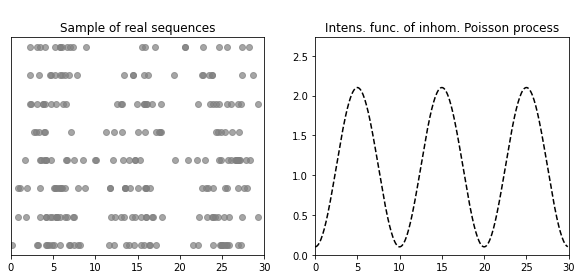

In [7]:
## plot sample of real sequences and the intensity function of the inhom. Poisson process
fig, axs = plt.subplots(1, 2, figsize=(10, 4), facecolor='w', edgecolor='k')

axs[0].set_xlim([0, max_T])
axs[0].set_yticks([])
axs[0].set_title("Sample of real sequences")
for i in range(min(8, SEQ_NUM)):
  axs[0].scatter(sequences_real[i], i*np.ones_like(sequences_real[i]), c="grey", alpha=0.7)

intens_func_f = sy.lambdify(x, intens_func, "numpy")
intens_func_x = np.arange(0, max_T, 0.1)
intens_func_y = intens_func_f(intens_func_x)
max_val = np.max(intens_func_y)
axs[1].set_xlim([0, max_T])
axs[1].set_ylim(0, 1.3*max_val)
axs[1].set_title("\nIntens. func. of inhom. Poisson process")
axs[1].plot(intens_func_x, intens_func_y, linestyle="--", alpha=1, color = 'black')

plt.show()

In [13]:
# Train WGAN model
LAMBDA_LP = 0.1 # regularization parameter (magnitude of Lipschitz penalty) in WGAN model

model_WGAN = WGAN(device=device, n_discr=5, hidden_dim=64, learn_rate=0.001, LAMBDA_LP=LAMBDA_LP)
model_WGAN.train(ITERS=5000, report_every=100,
                 iterator_real=iterator_real, iterator_noise=iterator_noise, max_T=max_T) # ~22min 30sec

Training Progress:    100 of   5000 || G_loss:   27.167 || D_loss:  -31.279
Training Progress:    200 of   5000 || G_loss:   54.099 || D_loss:  -90.562
Training Progress:    300 of   5000 || G_loss:   46.273 || D_loss:  -95.473
Training Progress:    400 of   5000 || G_loss:   63.987 || D_loss:  -84.940
Training Progress:    500 of   5000 || G_loss:   59.394 || D_loss: -117.342
Training Progress:    600 of   5000 || G_loss:   81.841 || D_loss: -133.694
Training Progress:    700 of   5000 || G_loss:  147.883 || D_loss:  -56.684
Training Progress:    800 of   5000 || G_loss:  123.243 || D_loss: -107.629
Training Progress:    900 of   5000 || G_loss: -135.197 || D_loss:    0.205
Training Progress:   1000 of   5000 || G_loss: -143.372 || D_loss:   -1.836
Training Progress:   1100 of   5000 || G_loss:  154.574 || D_loss:  -27.526
Training Progress:   1200 of   5000 || G_loss: -139.758 || D_loss:   -1.255
Training Progress:   1300 of   5000 || G_loss:   84.314 || D_loss:   27.646
Training Pro

In [10]:
# Train Sinkhorn model
beta = 30 # regularization parameter in Sinkhorn algorithm

model_Sinkhorn = Sinkhorn(device=device, hidden_dim=64, dropout_p=0.1, learn_rate=0.001,
                          n_sink=10, beta=beta, metric='xiao')
model_Sinkhorn.train(ITERS=2000, report_every=100,
                     iterator_real=iterator_real, iterator_noise=iterator_noise, max_T=max_T) # ~1min 25sec

Training Progress:    100 of   2000 || G_loss:  276.000 || G_loss (5-step moving avg):  276.000
Training Progress:    200 of   2000 || G_loss:  157.656 || G_loss (5-step moving avg):  216.828
Training Progress:    300 of   2000 || G_loss:  116.904 || G_loss (5-step moving avg):  183.520
Training Progress:    400 of   2000 || G_loss:   76.166 || G_loss (5-step moving avg):  156.682
Training Progress:    500 of   2000 || G_loss:   77.475 || G_loss (5-step moving avg):  140.840
Training Progress:    600 of   2000 || G_loss:   80.688 || G_loss (5-step moving avg):  101.778
Training Progress:    700 of   2000 || G_loss:   71.286 || G_loss (5-step moving avg):   84.504
Training Progress:    800 of   2000 || G_loss:   68.689 || G_loss (5-step moving avg):   74.861
Training Progress:    900 of   2000 || G_loss:   77.724 || G_loss (5-step moving avg):   75.172
Training Progress:   1000 of   2000 || G_loss:   67.337 || G_loss (5-step moving avg):   73.145
Training Progress:   1100 of   2000 || G

In [11]:
# Train IPOT model
beta = 30 # regularization parameter in IPOT algorithm

model_IPOT = IPOT(device=device, hidden_dim=64, dropout_p=0.1, learn_rate=0.001,
                  n_sink=1, n_ipot=10, beta=beta, metric='xiao')
model_IPOT.train(ITERS=2000, report_every=100,
                 iterator_real=iterator_real, iterator_noise=iterator_noise, max_T=max_T) # ~2min 44sec

Training Progress:    100 of   2000 || G_loss:  273.199 || G_loss (5-step moving avg):  273.199
Training Progress:    200 of   2000 || G_loss:  140.084 || G_loss (5-step moving avg):  206.642
Training Progress:    300 of   2000 || G_loss:   88.603 || G_loss (5-step moving avg):  167.295
Training Progress:    400 of   2000 || G_loss:   68.381 || G_loss (5-step moving avg):  142.567
Training Progress:    500 of   2000 || G_loss:   56.076 || G_loss (5-step moving avg):  125.268
Training Progress:    600 of   2000 || G_loss:   65.085 || G_loss (5-step moving avg):   83.646
Training Progress:    700 of   2000 || G_loss:   55.062 || G_loss (5-step moving avg):   66.641
Training Progress:    800 of   2000 || G_loss:   48.312 || G_loss (5-step moving avg):   58.583
Training Progress:    900 of   2000 || G_loss:   57.534 || G_loss (5-step moving avg):   56.414
Training Progress:   1000 of   2000 || G_loss:   57.751 || G_loss (5-step moving avg):   56.749
Training Progress:   1100 of   2000 || G

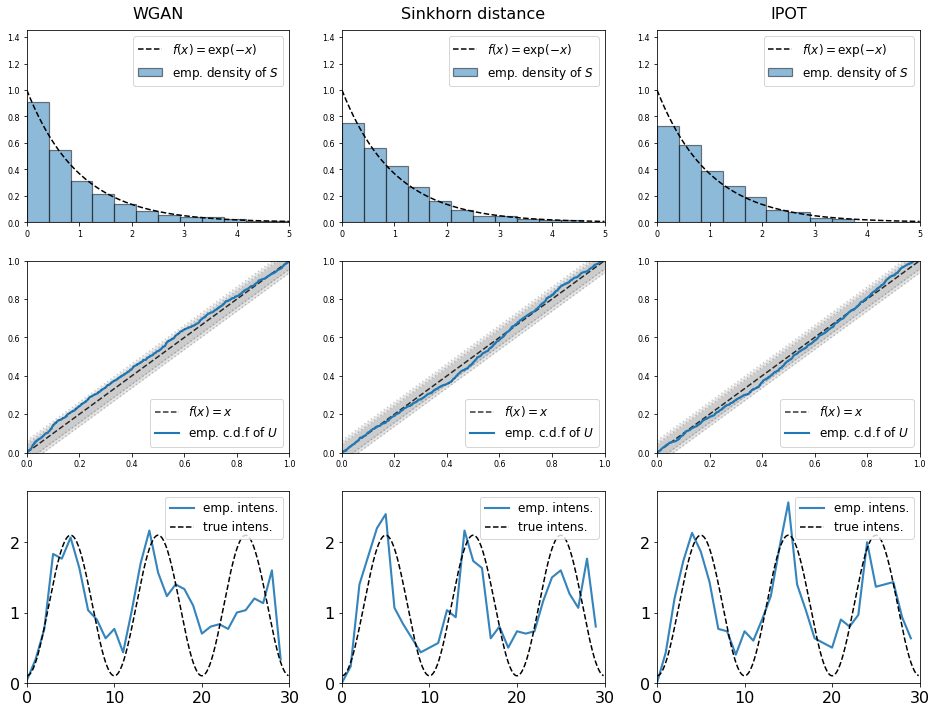

In [14]:
# perform residual analysis for all three generative models
# as theor. distribution is given by Poisson process we can also compare the emp. intensity given
# by the generated sequences with the true intensity given by the theor. Poisson process
generators=[model_WGAN.generator, model_Sinkhorn.generator, model_IPOT.generator]

# validation data (transformation by generators yields generated sequences which we use for residual analysis)
noise_tensor = val_data.batch_noise_seqs
noise_len_tensor = val_data.batch_noise_seqs_lens

plot_residual_analysis_compare_models(noise_tensor, noise_len_tensor, generators=generators, data_type=DATA, max_T=max_T, intens_func=intens_func, params=None, n_bins=12, conf_bands=True, plot_inten=True, size=4)

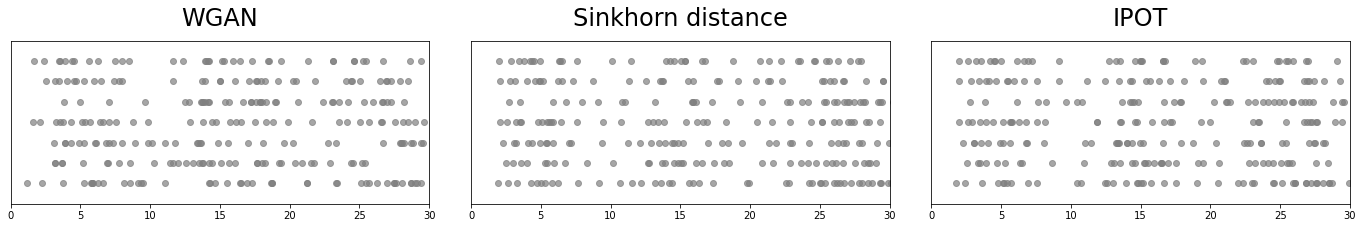

In [15]:
# generate for each model a sample of generated sequences
plot_gen_samples_compare_models(noise_tensor, noise_len_tensor, generators, max_T=max_T, size=3)

### Hawkes process
As second theoretical distibution we consider a Hawkes process and again compare the three generative models via the residual analysis. We let the point processes be constrained to the interval $[0,15]$ and use the Xiao-metric in all three models.

In [30]:
DATA = 'hawkes'
BATCH_SIZE = 32

## simulate real/observed data
max_T = 15 # maximum of time interval
SEQ_NUM = 2000 # number of samples of each point process

sequences_real = []
params_hawkes = {'alpha': 0.9,'mu': 0.6, 'omega': 1.0}
sequences_real = create_hawkes(params = params_hawkes, n_samples=SEQ_NUM, max_T=max_T)


## simulate noise samples
lambda0 = np.mean([len(item) for item in sequences_real])/max_T
sequences_noise = create_hom_poisson(mean=lambda0, n_samples=SEQ_NUM, max_T=max_T)


## initialize data iterators for batch-wise training
iterator_noise = PaddedDataIterator(sequences_noise, BATCH_SIZE, pad_elem = -1, sort_by_len=True)
iterator_real  = PaddedDataIterator(sequences_real, BATCH_SIZE, pad_elem = -1, sort_by_len=True)


## print summary statistics of the point process samples
max_seq_len = max([len(seq) for seq in sequences_noise+sequences_real])
avg_seq_len = np.round(np.mean([len(item) for item in sequences_real]), 2)


## Validation data
n_val_seqs = int(1000/(avg_seq_len)) # so that we have roughly 1000 points in all sequences combined
val_data = CreateValidationData(sequences_noise, sequences_real, n_seqs=n_val_seqs, device=device)


print("Number of sequences (with length > 2): %d (real process), %d (noise process)" %(len(sequences_real), len(sequences_noise)))
print("\nMaximal sequence length of real and noise process combined: %d" %(max_seq_len))
print("\nAverage number of points per sequence: ", avg_seq_len)

Number of sequences (with length > 2): 1717 (real process), 2000 (noise process)

Maximal sequence length of real and noise process combined: 235

Average number of points per sequence:  21.27


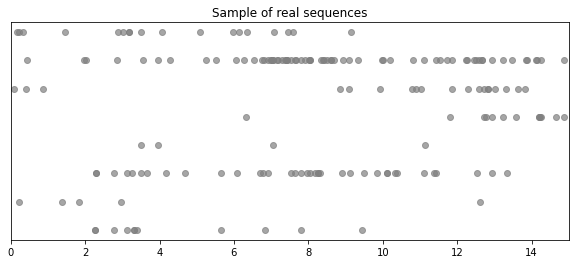

In [18]:
## plot sample of real/observed sequences
fig, axs = plt.subplots(1, figsize=(10, 4), facecolor='w', edgecolor='k')

axs.set_xlim([0, max_T])
axs.set_yticks([])
axs.set_title("Sample of real sequences")
for i in range(min(8, SEQ_NUM)):
  axs.scatter(sequences_real[i], i*np.ones_like(sequences_real[i]), c="grey", alpha=0.7)

plt.show()

In [19]:
# Train WGAN model
LAMBDA_LP = 0.1 # regularization parameter (magnitude of Lipschitz penalty) in WGAN model

model_WGAN = WGAN(device=device, n_discr=5, hidden_dim=64, learn_rate=0.001, LAMBDA_LP=LAMBDA_LP)
model_WGAN.train(ITERS=5000, report_every=100,
                 iterator_real=iterator_real, iterator_noise=iterator_noise, max_T=max_T) # ~16min 33sec

Training Progress:    100 of   5000 || G_loss:   51.337 || D_loss:  -63.207
Training Progress:    200 of   5000 || G_loss:  110.612 || D_loss: -130.625
Training Progress:    300 of   5000 || G_loss:   45.101 || D_loss: -124.702
Training Progress:    400 of   5000 || G_loss:  189.657 || D_loss: -161.414
Training Progress:    500 of   5000 || G_loss:  181.306 || D_loss: -135.484
Training Progress:    600 of   5000 || G_loss:  110.840 || D_loss:  -71.456
Training Progress:    700 of   5000 || G_loss:  269.890 || D_loss: -260.594
Training Progress:    800 of   5000 || G_loss:  297.782 || D_loss: -121.160
Training Progress:    900 of   5000 || G_loss:  143.672 || D_loss:  -21.151
Training Progress:   1000 of   5000 || G_loss:  315.589 || D_loss: -292.842
Training Progress:   1100 of   5000 || G_loss:  416.804 || D_loss: -418.350
Training Progress:   1200 of   5000 || G_loss:  208.684 || D_loss: -162.647
Training Progress:   1300 of   5000 || G_loss: -153.148 || D_loss:   30.063
Training Pro

In [20]:
# Train Sinkhorn model
beta = 30 # regularization parameter in Sinkhorn algorithm

model_Sinkhorn = Sinkhorn(device=device, hidden_dim=64, dropout_p=0.1, learn_rate=0.001,
                          n_sink=10, beta=beta, metric='xiao')
model_Sinkhorn.train(ITERS=2000, report_every=100,
                     iterator_real=iterator_real, iterator_noise=iterator_noise, max_T=max_T,
                     n_sink_TT=1, n_ipot_TT=10, beta_TT=max_T/20, algo_TT='ipot') # ~1min 15sec

Training Progress:    100 of   2000 || G_loss:  102.310 || G_loss (5-step moving avg):  102.310
Training Progress:    200 of   2000 || G_loss:   74.674 || G_loss (5-step moving avg):   88.492
Training Progress:    300 of   2000 || G_loss:   52.522 || G_loss (5-step moving avg):   76.502
Training Progress:    400 of   2000 || G_loss:   55.540 || G_loss (5-step moving avg):   71.262
Training Progress:    500 of   2000 || G_loss:   44.673 || G_loss (5-step moving avg):   65.944
Training Progress:    600 of   2000 || G_loss:   55.775 || G_loss (5-step moving avg):   56.637
Training Progress:    700 of   2000 || G_loss:   50.683 || G_loss (5-step moving avg):   51.839
Training Progress:    800 of   2000 || G_loss:   47.539 || G_loss (5-step moving avg):   50.842
Training Progress:    900 of   2000 || G_loss:   51.378 || G_loss (5-step moving avg):   50.010
Training Progress:   1000 of   2000 || G_loss:   89.899 || G_loss (5-step moving avg):   59.055
Training Progress:   1100 of   2000 || G

In [21]:
# Train IPOT model
beta = 30 # regularization parameter in IPOT algorithm

model_IPOT = IPOT(device=device, hidden_dim=64, dropout_p=0.1, learn_rate=0.001,
                  n_sink=1, n_ipot=10, beta=beta, metric='xiao')
model_IPOT.train(ITERS=2000, report_every=100,
                 iterator_real=iterator_real, iterator_noise=iterator_noise, max_T=max_T,
                 n_sink_TT=1, n_ipot_TT=10, beta_TT=max_T/20, algo_TT='ipot') # ~2min 53sec

Training Progress:    100 of   2000 || G_loss:   82.153 || G_loss (5-step moving avg):   82.153
Training Progress:    200 of   2000 || G_loss:   43.254 || G_loss (5-step moving avg):   62.704
Training Progress:    300 of   2000 || G_loss:   40.330 || G_loss (5-step moving avg):   55.246
Training Progress:    400 of   2000 || G_loss:   44.776 || G_loss (5-step moving avg):   52.628
Training Progress:    500 of   2000 || G_loss:   36.698 || G_loss (5-step moving avg):   49.442
Training Progress:    600 of   2000 || G_loss:   34.836 || G_loss (5-step moving avg):   39.979
Training Progress:    700 of   2000 || G_loss:   35.852 || G_loss (5-step moving avg):   38.498
Training Progress:    800 of   2000 || G_loss:   36.346 || G_loss (5-step moving avg):   37.701
Training Progress:    900 of   2000 || G_loss:   39.010 || G_loss (5-step moving avg):   36.548
Training Progress:   1000 of   2000 || G_loss:   49.240 || G_loss (5-step moving avg):   39.057
Training Progress:   1100 of   2000 || G

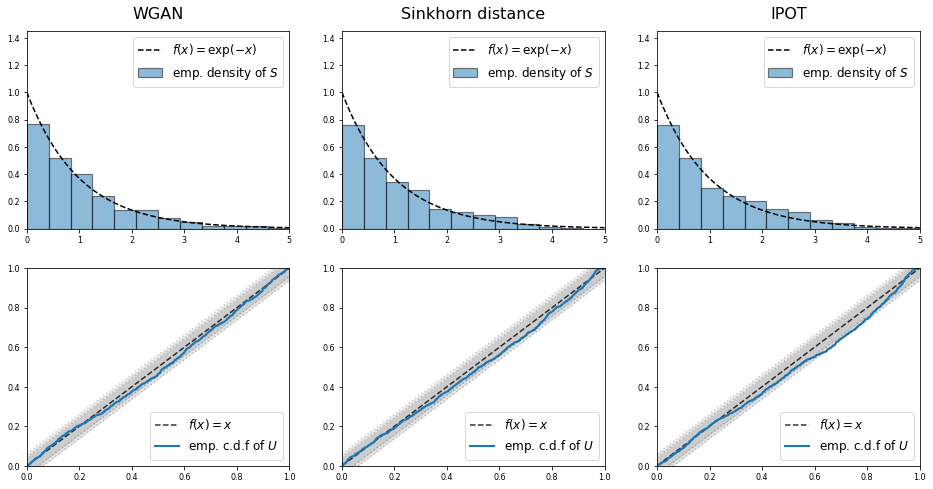

In [31]:
# perform residual analysis for all three generative models
generators=[model_WGAN.generator, model_Sinkhorn.generator, model_IPOT.generator]

# validation data (transformation by generators yields generated sequences which we use for residual analysis)
noise_tensor = val_data.batch_noise_seqs
noise_len_tensor = val_data.batch_noise_seqs_lens

plot_residual_analysis_compare_models(noise_tensor, noise_len_tensor, generators=generators, data_type="hawkes", max_T=max_T, params=params_hawkes, n_bins=12, conf_bands=True, plot_inten=False, size=4)

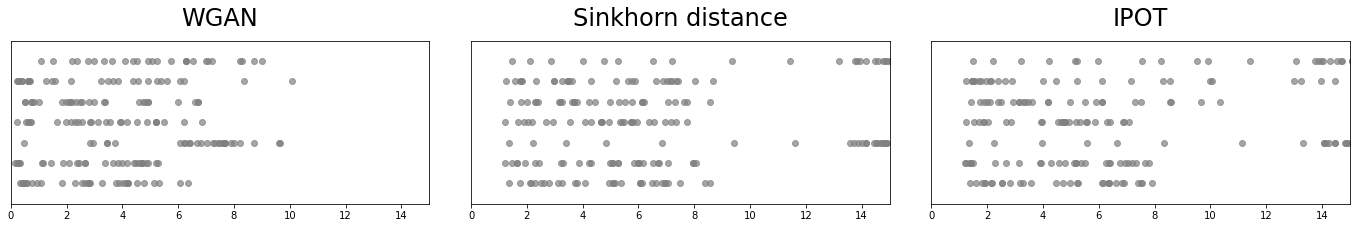

In [32]:
# generate for each model a sample of generated sequences
plot_gen_samples_compare_models(noise_tensor, noise_len_tensor, generators, max_T=max_T, size=3)

### Further analysis
We choose the IPOT model as the generative model on which we apply further analysis. The further analysis consists of two parts.

First, we analyse the influence of the sequence metric (Xiao-metric or TT-metric) in the training of the generative model by systematically choosing the mean intensity of the noise process to be smaller, bigger or equal the mean intensity of the observed/real process. After the training we assess the empirical intensity of the generated sequences where we use an inhom. Poisson process as the real process. 

Secondly, we check our model for overfitting. A common approach in generative models is to assess how close the generated data is to the observed data in terms of an appropiate metric. If the generated sequences merely copy the sample of observed sequences rather than representing an authentic new sample of observed sequences, this would account for an overfitting.

In [33]:
DATA = 'inhom_poisson_gauss_kernels' # choose either: hawkes, inhom_poisson, inhom_poisson_gauss_kernels; specify distributions below
BATCH_SIZE = 32

## simulate real/observed data
max_T = 200 # maximum of time interval
SEQ_NUM = 2000 # number of samples of each point process

gauss_params = dict()
gauss_params['coef'] = [10, 2]  # sum of these numbers ~ average number of points per sequence
gauss_params['center'] = [50, 100]
gauss_params['std'] = [40, 1000]  # high std in second kernel in order to ensure intensity is not too close to 0 on interval

n_kernels = len(gauss_params['coef'])
intensityPoissonGaussianKernels = IntensitySumGaussianKernel(k=2, centers=gauss_params['center'], stds=gauss_params['std'], coefs=gauss_params['coef'])
sequences_real = create_inhom_poisson_gauss_kernels(intensityPoissonGaussianKernels, n_samples=SEQ_NUM, max_T=max_T)


## simulate noise samples where the mean intensity of noise process varies in relation to real process
lambda0 = np.mean([len(item) for item in sequences_real])/max_T
seqs_noise_mean_intens_equal = create_hom_poisson(mean = lambda0, n_samples=SEQ_NUM, max_T=max_T)
seqs_noise_mean_intens_bigger = create_hom_poisson(mean = 1.3*lambda0, n_samples=SEQ_NUM, max_T=max_T)
seqs_noise_mean_intens_smaller = create_hom_poisson(mean = 0.7*lambda0, n_samples=SEQ_NUM, max_T=max_T)


## initialize data iterators for batch-wise training
iterator_noise_equal = PaddedDataIterator(seqs_noise_mean_intens_equal, BATCH_SIZE, pad_elem = -1, sort_by_len=True)
iterator_noise_bigger = PaddedDataIterator(seqs_noise_mean_intens_bigger, BATCH_SIZE, pad_elem = -1, sort_by_len=True)
iterator_noise_smaller = PaddedDataIterator(seqs_noise_mean_intens_smaller, BATCH_SIZE, pad_elem = -1, sort_by_len=True)
iterator_real  = PaddedDataIterator(sequences_real, BATCH_SIZE, pad_elem = -1, sort_by_len=True)

avg_seq_len = np.round(np.mean([len(item) for item in sequences_real]), 2)

## Validation data
n_val_seqs = int(1000/(avg_seq_len)) # so that we have roughly 1000 points in all sequences combined
val_data_noise_equal = CreateValidationData(seqs_noise_mean_intens_equal, sequences_real, n_seqs=n_val_seqs, device=device)
val_data_noise_bigger = CreateValidationData(seqs_noise_mean_intens_bigger, sequences_real, n_seqs=int(1.3*n_val_seqs), device=device)
val_data_noise_smaller = CreateValidationData(seqs_noise_mean_intens_smaller, sequences_real, n_seqs=int(0.7*n_val_seqs), device=device)

print("Average number of points per sequence (real sequences): ", avg_seq_len)
print("Average number of points per sequence (noise sequences with equal mean intensity): ", avg_seq_len)
print("Average number of points per sequence (noise sequences with bigger mean intensity): ", np.round(1.3*avg_seq_len, 2))
print("Average number of points per sequence (noise sequences with smaller intensity): ", np.round(0.7*avg_seq_len, 2))

Average number of points per sequence (real sequences):  9.18
Average number of points per sequence (noise sequences with equal mean intensity):  9.18
Average number of points per sequence (noise sequences with bigger mean intensity):  11.93
Average number of points per sequence (noise sequences with smaller intensity):  6.43


In [34]:
# Train IPOT model w.r.t. xiao or TT metric where intensity of noise process is equal to intensity of real process (default)
print("Train IPOT model using Xiao-metric and noise sequences with mean intensity equal to mean intensity of real sequences:")
model_IPOT_xiao_equal = IPOT(device=device, learn_rate=0.01,
                             n_sink=1, n_ipot=10, beta=200, metric='xiao')
model_IPOT_xiao_equal.train(ITERS=1000, report_every=200,
                            iterator_real=iterator_real, iterator_noise=iterator_noise_equal, max_T=max_T)

print("\nTrain IPOT model using T-metric and noise sequences with mean intensity equal to mean intensity of real sequences:")
model_IPOT_TT_equal = IPOT(device=device, learn_rate=0.01,
                           n_sink=1, n_ipot=10, beta=200, metric='TT')
model_IPOT_TT_equal.train(ITERS=1000, report_every=200,
                          iterator_real=iterator_real, iterator_noise=iterator_noise_equal, max_T=max_T,
                          n_sink_TT=1, n_ipot_TT=10, beta_TT=max_T/20, algo_TT='ipot')

Train IPOT model using Xiao-metric and noise sequences with mean intensity equal to mean intensity of real sequences:
Training Progress:    200 of   1000 || G_loss:  225.223 || G_loss (5-step moving avg):  225.223
Training Progress:    400 of   1000 || G_loss:  138.661 || G_loss (5-step moving avg):  181.942
Training Progress:    600 of   1000 || G_loss:  198.435 || G_loss (5-step moving avg):  187.440
Training Progress:    800 of   1000 || G_loss:  227.077 || G_loss (5-step moving avg):  197.349
Training Progress:   1000 of   1000 || G_loss:  124.932 || G_loss (5-step moving avg):  182.866

Train IPOT model using T-metric and noise sequences with mean intensity equal to mean intensity of real sequences:
Training Progress:    200 of   1000 || G_loss:  854.340 || G_loss (5-step moving avg):  854.340
Training Progress:    400 of   1000 || G_loss:  616.499 || G_loss (5-step moving avg):  735.420
Training Progress:    600 of   1000 || G_loss:  519.420 || G_loss (5-step moving avg):  663.42

In [35]:
# Train IPOT model w.r.t. xiao or TT metric where intensity of noise process is bigger than intensity of real process
print("Train IPOT model using Xiao-metric and noise sequences with mean intensity bigger than mean intensity of real sequences:")
model_IPOT_xiao_bigger = IPOT(device=device, learn_rate=0.01,
                              n_sink=1, n_ipot=10, beta=200, metric='xiao')
model_IPOT_xiao_bigger.train(ITERS=1000, report_every=200,
                             iterator_real=iterator_real, iterator_noise=iterator_noise_bigger, max_T=max_T)

print("\nTrain IPOT model using TT-metric and noise sequences with mean intensity bigger than mean intensity of real sequences:")
model_IPOT_TT_bigger = IPOT(device=device, learn_rate=0.01,
                            n_sink=1, n_ipot=10, beta=200, metric='TT')
model_IPOT_TT_bigger.train(ITERS=1000, report_every=200,
                           iterator_real=iterator_real, iterator_noise=iterator_noise_bigger, max_T=max_T,
                           n_sink_TT=1, n_ipot_TT=10, beta_TT=max_T/20, algo_TT='ipot')

Train IPOT model using Xiao-metric and noise sequences with mean intensity bigger than mean intensity of real sequences:
Training Progress:    200 of   1000 || G_loss:  342.919 || G_loss (5-step moving avg):  342.919
Training Progress:    400 of   1000 || G_loss:  264.373 || G_loss (5-step moving avg):  303.646
Training Progress:    600 of   1000 || G_loss:  245.308 || G_loss (5-step moving avg):  284.200
Training Progress:    800 of   1000 || G_loss:  172.337 || G_loss (5-step moving avg):  256.234
Training Progress:   1000 of   1000 || G_loss:  181.043 || G_loss (5-step moving avg):  241.196

Train IPOT model using TT-metric and noise sequences with mean intensity bigger than mean intensity of real sequences:
Training Progress:    200 of   1000 || G_loss: 1047.376 || G_loss (5-step moving avg): 1047.376
Training Progress:    400 of   1000 || G_loss: 1250.515 || G_loss (5-step moving avg): 1148.946
Training Progress:    600 of   1000 || G_loss:  830.179 || G_loss (5-step moving avg): 

In [37]:
# Train IPOT model w.r.t. xiao or TT metric where intensity of noise process is smaller than intensity of real process
print("Train IPOT model using Xiao-metric and noise sequences with mean intensity smaller than mean intensity of real sequences:")
model_IPOT_xiao_smaller = IPOT(device=device, learn_rate=0.01,
                               n_sink=1, n_ipot=10, beta=200, metric='xiao')
model_IPOT_xiao_smaller.train(ITERS=1000, report_every=200,
                              iterator_real=iterator_real, iterator_noise=iterator_noise_smaller, max_T=max_T)

print("\nTrain IPOT model using TT-metric and noise sequences with mean intensity bigger than mean intensity of real sequences:")
model_IPOT_TT_smaller = IPOT(device=device, learn_rate=0.01,
                             n_sink=1, n_ipot=10, beta=200, metric='TT')
model_IPOT_TT_smaller.train(ITERS=1000, report_every=200,
                            iterator_real=iterator_real, iterator_noise=iterator_noise_smaller, max_T=max_T,
                            n_sink_TT=1, n_ipot_TT=10, beta_TT=max_T/20, algo_TT='ipot')

Train IPOT model using Xiao-metric and noise sequences with mean intensity smaller than mean intensity of real sequences:
Training Progress:    200 of   1000 || G_loss:  253.753 || G_loss (5-step moving avg):  253.753
Training Progress:    400 of   1000 || G_loss:  301.360 || G_loss (5-step moving avg):  277.557
Training Progress:    600 of   1000 || G_loss:  309.125 || G_loss (5-step moving avg):  288.080
Training Progress:    800 of   1000 || G_loss:  269.172 || G_loss (5-step moving avg):  283.353
Training Progress:   1000 of   1000 || G_loss:  293.772 || G_loss (5-step moving avg):  285.437

Train IPOT model using TT-metric and noise sequences with mean intensity bigger than mean intensity of real sequences:
Training Progress:    200 of   1000 || G_loss:  499.937 || G_loss (5-step moving avg):  499.937
Training Progress:    400 of   1000 || G_loss:  501.417 || G_loss (5-step moving avg):  500.677
Training Progress:    600 of   1000 || G_loss:  516.073 || G_loss (5-step moving avg):

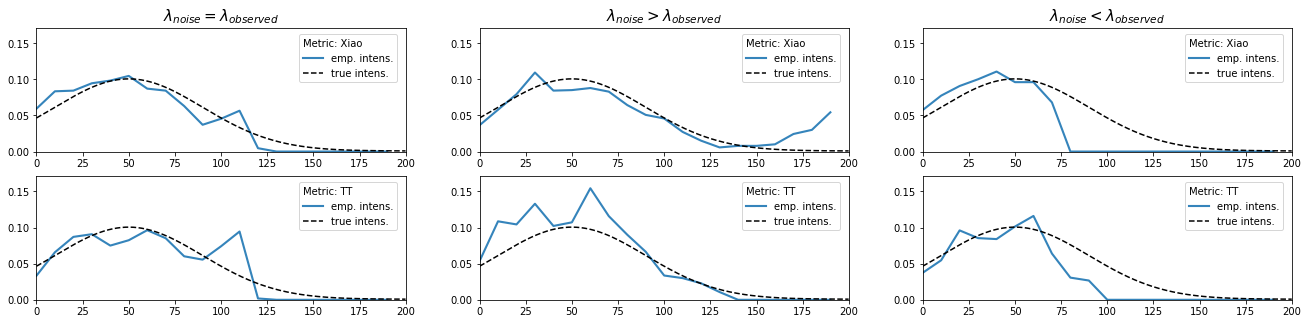

In [38]:
# compare trained IPOT models by assessing the empirical intensities of the generated sequences 
x = sy.Symbol("x")
intens_func = intens_func_from_gauss_params(gauss_params)

# order in the lists w.r.t. equal/bigger/smaller and xiao/TT has to be hold for the plotting
val_data_list = [val_data_noise_equal, val_data_noise_bigger, val_data_noise_smaller]
generators = [model_IPOT_xiao_equal.generator, model_IPOT_TT_equal.generator,
              model_IPOT_xiao_bigger.generator, model_IPOT_TT_bigger.generator,
              model_IPOT_xiao_smaller.generator, model_IPOT_TT_smaller.generator]

plot_metric_comparision_vary_noise_mean_intens(
    val_data_list=val_data_list,
    generators=generators,
    intens_func=intens_func,
    max_T=max_T,
    size=2.5)

In [39]:
## train a new generative model (IPOT) to see if the model is overfitting
## use a Hawkes process for the simulation of the real data

DATA = 'hawkes'
BATCH_SIZE = 32

## simulate real/observed data
max_T = 15 # maximum of time interval
SEQ_NUM = 2000 # number of samples of each point process

sequences_real = []
params_hawkes = {'alpha': 0.9,'mu': 0.6, 'omega': 1.0}
sequences_real = create_hawkes(params = params_hawkes, n_samples=SEQ_NUM, max_T=max_T)

## simulate noise samples
lambda0 = np.mean([len(item) for item in sequences_real])/max_T
sequences_noise = create_hom_poisson(mean=lambda0, n_samples=SEQ_NUM, max_T=max_T)

## initialize data iterators for batch-wise training
iterator_noise = PaddedDataIterator(sequences_noise, BATCH_SIZE, pad_elem = -1, sort_by_len=True)
iterator_real  = PaddedDataIterator(sequences_real, BATCH_SIZE, pad_elem = -1, sort_by_len=True)

## Validation data
n_val_seqs = int(1000/(avg_seq_len)) # so that we have roughly 1000 points in all sequences combined
val_data = CreateValidationData(sequences_noise, sequences_real, n_seqs=n_val_seqs, device=device)

## Train IPOT model
model_IPOT = IPOT(device=device, learn_rate=0.01,
                  n_sink=1, n_ipot=10, beta=max_T, metric='xiao')
model_IPOT.train(ITERS=1500, report_every=100,
                 iterator_real=iterator_real, iterator_noise=iterator_noise, max_T=max_T)

Training Progress:    100 of   1500 || G_loss:   46.221 || G_loss (5-step moving avg):   46.221
Training Progress:    200 of   1500 || G_loss:   36.740 || G_loss (5-step moving avg):   41.481
Training Progress:    300 of   1500 || G_loss:   34.047 || G_loss (5-step moving avg):   39.003
Training Progress:    400 of   1500 || G_loss:   37.710 || G_loss (5-step moving avg):   38.679
Training Progress:    500 of   1500 || G_loss:   39.200 || G_loss (5-step moving avg):   38.784
Training Progress:    600 of   1500 || G_loss:   56.239 || G_loss (5-step moving avg):   40.787
Training Progress:    700 of   1500 || G_loss:   48.981 || G_loss (5-step moving avg):   43.235
Training Progress:    800 of   1500 || G_loss:   34.107 || G_loss (5-step moving avg):   43.248
Training Progress:    900 of   1500 || G_loss:   46.651 || G_loss (5-step moving avg):   45.036
Training Progress:   1000 of   1500 || G_loss:   36.491 || G_loss (5-step moving avg):   44.494
Training Progress:   1100 of   1500 || G

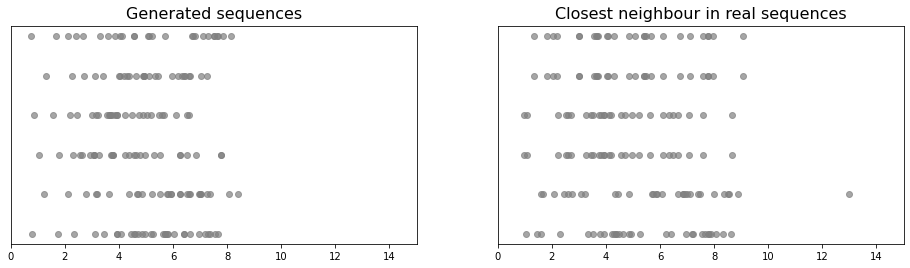

In [40]:
# check for overfitting by comparing each generated sequence to its closest neighbour (w.r.t. Xiao-metric) in set of observed sequences
noise_tensor = val_data.batch_noise_seqs
noise_len_tensor = val_data.batch_noise_seqs_lens

gen_seqs = retrieve_seqs_from_gen(noise_tensor, noise_len_tensor, model_IPOT.generator)

plot_min_xiao_dist_gen_to_obs(gen_seqs, sequences_real, max_T=max_T, size=4)